#### Laurent Jutras-Dubé

## The gene-free models: deterministic simulations

####   

**1. Pattern formation with the gene-free models**

In this notebook, we perform deterministic simulations of the gene-free Models 1 (which undergoes a SNIC bifurcation) and 2 (which undergoes a Hopf bifurcation). See the Methods and the Supplement for a detailed description of the models.

In [1]:
%matplotlib notebook
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
from matplotlib.animation import (FuncAnimation, writers)
rcParams.update({'figure.max_open_warning': 0})

####    

**1.1 The ODEs**

In polar coordinates, the ODEs for the dynamic term $D(y,z)$ are the following:

\begin{align}
\dot{r} &= r \big(1-r \big) \\
\dot{\theta} &= 1
\end{align}

where $r = \sqrt{y^2+z^2}$ is the distance from the origin [$y$, $z$] = [0, 0], and $\theta = \tan^{-1}(y/z)$ is the angle from the positive $y$ axis. These equations can be rewritten in cartesian coordinates:

\begin{align}
\dot{y} &= y \bigg(1-\sqrt{y^2+z^2} \bigg) -z \\
\dot{z} &= z \bigg(1-\sqrt{y^2+z^2} \bigg) +y
\end{align}

The static term $S(y,z)$ is given by the following ODEs:

\begin{align}
\dot{y} &= y \big(1-y^2 \big) \\
\dot{z} &= -z
\end{align}

Gene-free Model 2 includes these two terms and parameter $g$ in the following way:

\begin{equation}
\dot{P} = g \: D(P) + (1-g) \: S(P)
\end{equation}

where $P$ is the vector of components $y$ and $z$. In this notebook, we show that, with such linear weights for $g$, the gene-free model undergoes a SNIC bifurcation (as $g$ decreases rom 1 to 0). To get a Hopf bifurcation, we follow a similar approach than for the 3-gene model. We reasoned that the sum of the weights in front of the dynamic and static modules should become smaller than a degradation-like term for values of $g$ around 0.5. Therefore, we include a third term in the model, the "intermediate term" $I(y,z)$, with a single stable fixed point at the origin:

\begin{align}
\dot{y} &= -y \\
\dot{z} &= -z
\end{align}

Gene-free Model 1 includes the 3 terms and parameter $g$ in the following way:

\begin{equation}
\dot{P} = g^3 \: D(P) + (1-g)^3 \: S(P) +g \: (1-g) \: I(P)
\end{equation}

Recall that in a given cell, only the dynamic module should be present at the beginning of the simulation, when $g=1$. Similarly, only the static module should be present at the end of the simulation, when $g=0$. Therefore, we set the weight of the intermediate module equal to $g \: (1-g)$, which is zero at both $g=1$ and $g=0$. Since this weight is of the order 2 in $g$, we make the weights in front of the dynamic and static modules of the order 3 in $g$ to ensure that they become smaller than the weight of the intermediate term for $g$ around 0.5. 

Note that in the gene-free Model 1, the fixed points defining the two regions of the pattern form via a pitchfork bifurcation. This is slightly different than the saddle-node bifurcations that occur in the 3-gene Model 1.

In the following code cell, we define functions for the dynamic, static and intermediate terms, and a total derivative function that also includes parameter $g$. We specify the values of all parameters in a dictionary later in the notebook.

In [2]:
def dynamic(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    r = np.sqrt(y*y+z*z)
    
    dy = y*(1.-r) -z
    dz = z*(1.-r) +y
    
    return np.array([dy, dz]).transpose()



def static(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    
    dy = y*(1.-y*y)
    dz = -z
    
    return np.array([dy, dz]).transpose()



def intermediate(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    
    dy = -y
    dz = -z
    
    return np.array([dy, dz]).transpose()



def dvec(vec, g, param):
    
    g = np.array([g, g]).transpose()
    ng = param["ng"]
    if_interm = param["if_interm"]
    
    return g**ng*dynamic(vec) +(1.-g)**ng*static(vec) +if_interm*g*(1.-g)*intermediate(vec)

####    

**1.2 The spatio-temporal profile of parameter _g_**

In a given cell, the value of $g$ stays equal to 1 for some time (via the `x_osc` parameter) before decreasing exponentially (via the `s` parameter). To generate a spatial pattern, we make the time at which the value of $g$ starts decreasing, $t^*$, dependent on the position of the cell in the tissue: $t^*(x)$. To model a tissue growing with a constant speed, we make $t^*(x)$ a linear function of $x$, via the `positions` vector and the `v` parameter. In other words, we model a gradient of $g$ with a fixed steepness that moves in the posterior direction at a constant rate. We generate a kymograph showing the spatio-temporal profile of $g$ later in this notebook.

In [3]:
def compute_g(t, param):
    
    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    positions = np.linspace(0.0, 1.0, param["n_cells"])
    
    g = np.exp(s*(positions +x_osc -v*t))
    g[g > 1.] = 1.
    
    return g

####  

**1.3 The integration scheme**

We use the Euler integration scheme to perform the integration of the ODEs describing the dynamics of variables $y$ and $z$. The `integrate` function requires two inputs: the initial values of the two variables at all spatial positions, and the dictionary of parameters. Parameter `n_steps_keep_results` specifies the number of integration steps between which the simulation results are kept. Increasing this parameter can help reduce the size of the 3 output matrices, `results`, `g_gradient` and `times_plot`. These matrices contain respectively the values of the variables at all positions for every time point, the spatio-temporal distribution of parameter $g$ and the array of times.

In [4]:
def integrate(init_vec, param):

    # Set the integration parameters
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)
    times_plot = [0.]

    vec = init_vec
    results = [vec]
    g = compute_g(0., param)
    g_gradient = [g]
    
    counter = 0
    n_steps_keep_results = param["n_steps_keep_results"]

    
    # Perform the integration
    for t in times[1:]:
        
        vec = vec +dvec(vec, g, param)*dt
        
        g = compute_g(t, param)
           
        counter += 1
        if (counter %n_steps_keep_results == 0):
            results.append(vec)
            g_gradient.append(g)
            times_plot.append(t)
        

    # Output the results
    results = np.array(results)
    g_gradient = np.array(g_gradient)
    times_plot = np.array(times_plot)
    
    return results, g_gradient, times_plot

####  

**1.4 The kymograph plots**

We visualize the results of the integration with a kymograph where the horizontal axis is time and the vertical axis is the position of the cell along the tissue. On this kymograph, we represent the value of the $y$ component with a color gradient. We do not represent the $z$ component since it is always equal to 0 in the spatial pattern, and therefore does not provide any positional information.

We plot lines representing the moment at which $g$ starts decreasing for the different positions along the tissue. We also plot lines for the moments at which $g$ reaches specific values, namely 0.5 and 0.2. To achieve this, we need to define a function `compute_x` that outputs the position of the cell that has a given value of $g$ at a given time, and a function `compute_t` that outputs the time at which $g$ has a given value at a given position along the tissue.

In [5]:
def compute_x(g, t, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return np.log(g)/s -x_osc +v*t



def compute_t(g, x, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return (x_osc +x -np.log(g)/s)/v
    

    
def plot_kymograph(results, g_gradient, times_plot, param):
    
    plt.rcParams["figure.figsize"] = 6.4, 4.8
    fig, ax = plt.subplots()
    
    # Kymograph
    norm = colors.Normalize(vmin=-1., vmax=1.)
    kymo = ax.imshow(results[:,:,0].transpose(), norm=norm, cmap='Blues', aspect='auto')
    
    # Colorbar
    cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[-1., 0., 1.])
    cb.ax.tick_params(labelsize=24)
    
    # Lines of constant g
    ax.plot(param["n_cells"]*compute_x(1., times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.5, times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.2, times_plot, param), color='k', linewidth=4)
    
    ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=1$', color='k', rotation=-76, fontsize=24)
    ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.5$', color='k', rotation=-76, fontsize=24)
    ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.2$', color='k', rotation=-76, fontsize=24)
    
    # Other plot options
    if (param["if_interm"] == 1.):    version = '1'
    else:    version = '2'
    
    ax.set_title('Model '+version+'       $y(x,t)$', fontsize=32)
    ax.set_xlabel('$t$', fontsize=32)
    ax.set_ylabel('$x$', fontsize=32)
    ax.set_ylim([param["n_cells"], 0])
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.show()

####  

**1.5 The dynamics of pattern formation in the gene-free models**

We define all the parameters required for the ODEs, the gradient of parameter $g$ and the integration. We then use the `integrate` function to perform the integration and the `plot_kymograph` function to visualise the results. In Model 1, we set `ng` to 3 and `if_interm` to 1, while in Model 2 we set `ng` to 1 and `if_interm` to 0.

<IPython.core.display.Javascript object>


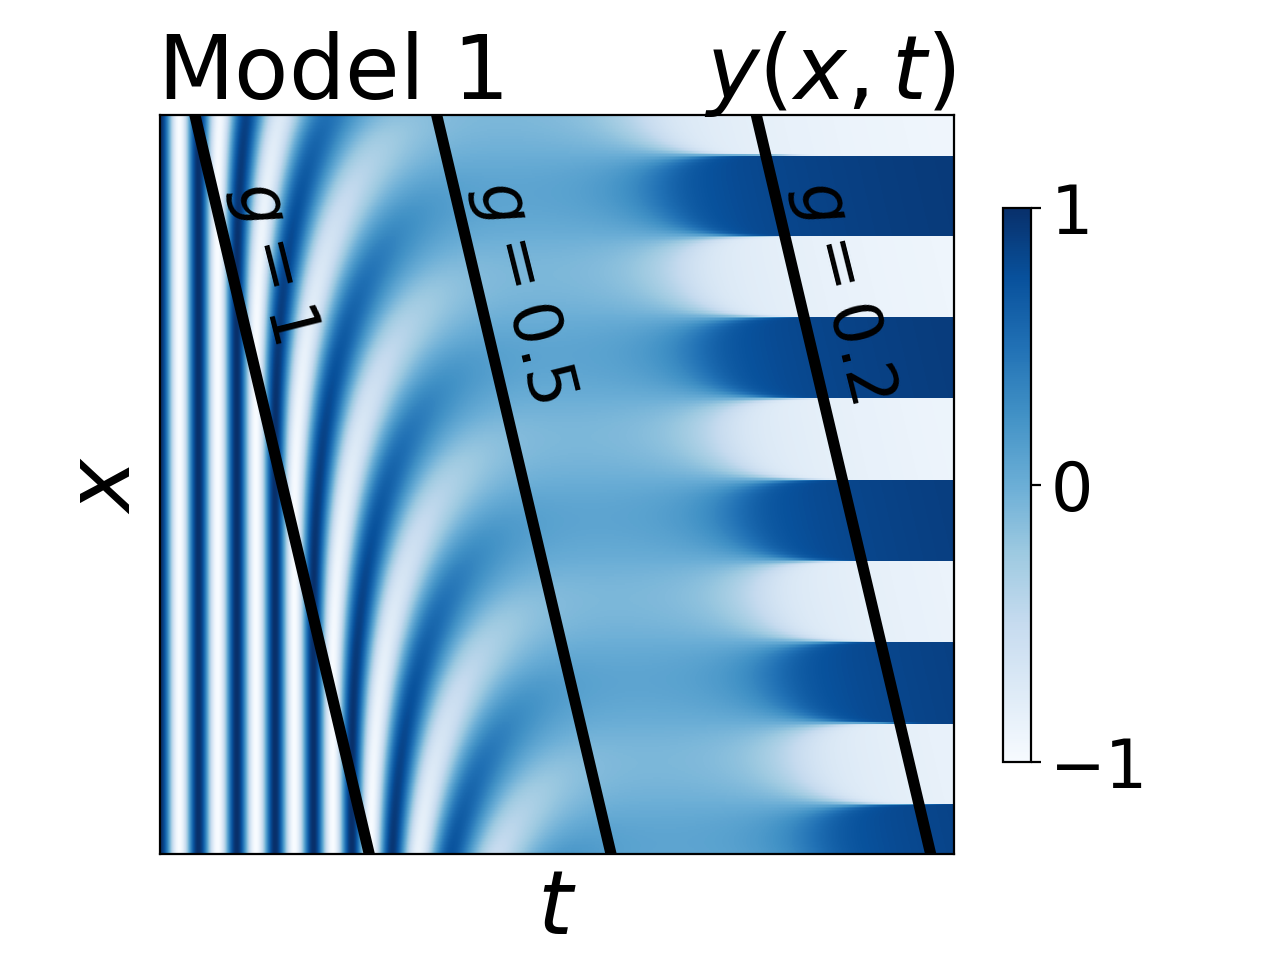

<IPython.core.display.Javascript object>


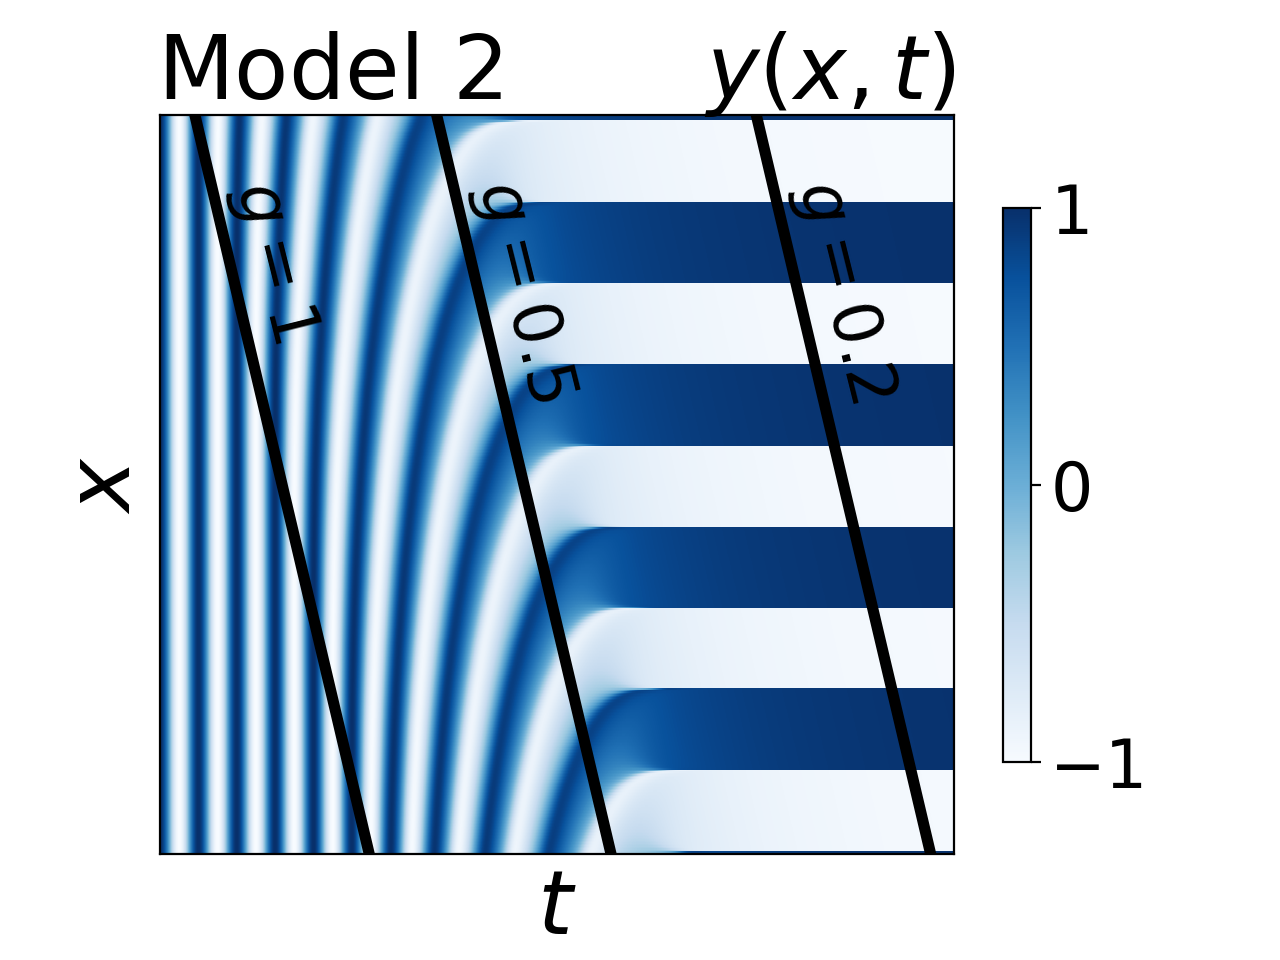

In [6]:
param ={
    
    # ODE parameters
    "ng"        : 3,
    "if_interm" : 1.,
    
    # Morphogen gradient parameters
    "x_osc"   : 0.2,
    "s"       : 0.5,
    "v"       : 0.035,
    "n_cells" : 500,
    
    # Integration parameters
    "total_t"                : 130.,
    "dt"                     : 0.01,
    "n_steps_keep_results"   : 1 
}


init_vec = np.zeros((param["n_cells"], 2))
init_vec[:,0] = 1.


# Gene-free model with a Hopf bifurcation (Model 1)
param["ng"] = 3
param["if_interm"] = 1.
results_Hopf, g_gradient_Hopf, times_plot_Hopf = integrate(init_vec, param)
plot_kymograph(results_Hopf, g_gradient_Hopf, times_plot_Hopf, param)


# Gene-free model with a SNIC bifurcation (Model 2)
param["ng"] = 1
param["if_interm"] = 0.
results_SNIC, g_gradient_SNIC, times_plot_SNIC = integrate(init_vec, param)
plot_kymograph(results_SNIC, g_gradient_SNIC, times_plot_SNIC, param)

On both kymographs, we clearly see the well-defined pattern obtained at the end of the simulation, and the slowing down of the oscillations in single cells. For the Hopf model, we also see that all cells reach a similar state for values of $g$ around 0.5. Like in the 3-gene model, this is due to the Hopf bifurcation that transforms the oscillations into a single stable fixed point. We generate the bifurcation diagram for both versions of the model in the next section of this notebook.

In the next code cell, we plot the values of the $y$ and $z$ components in a single cell as a function of time for both versions of the model. We choose arbitrarily the most anterior cell.

<IPython.core.display.Javascript object>


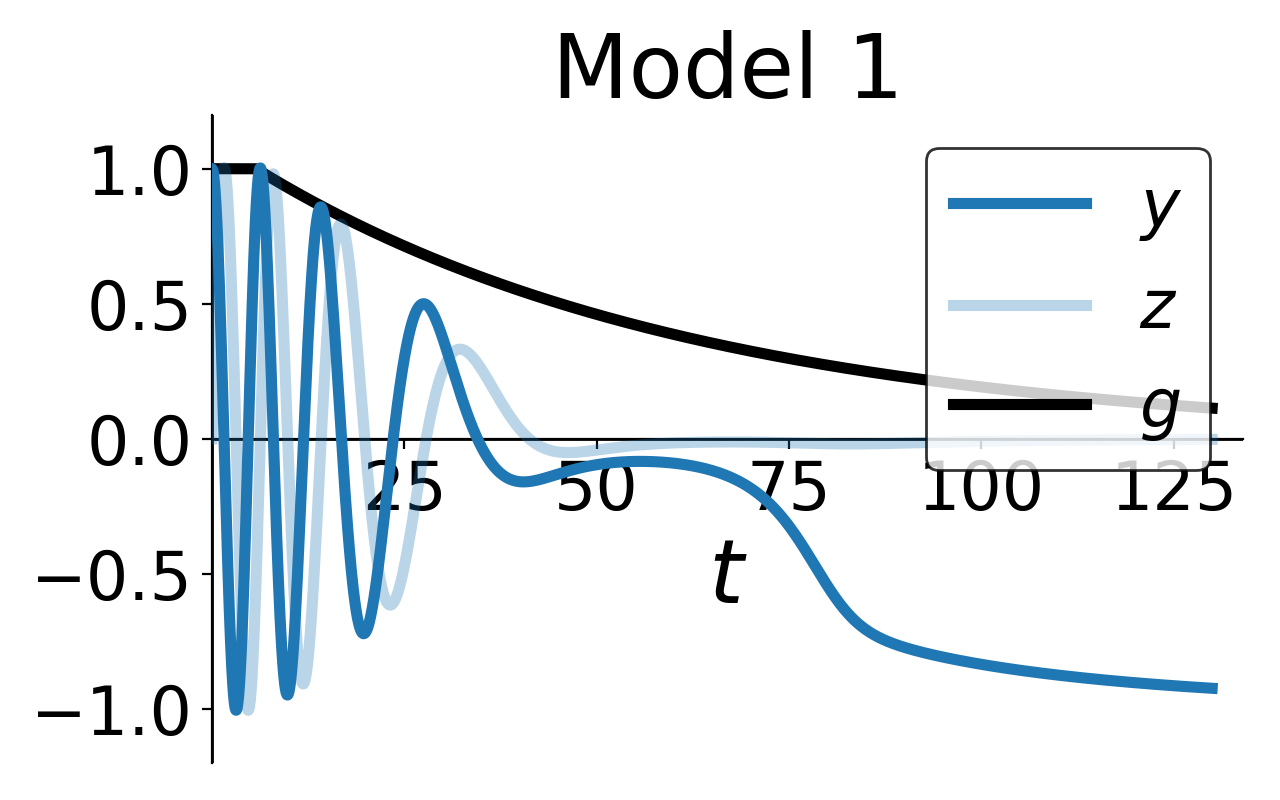

<IPython.core.display.Javascript object>


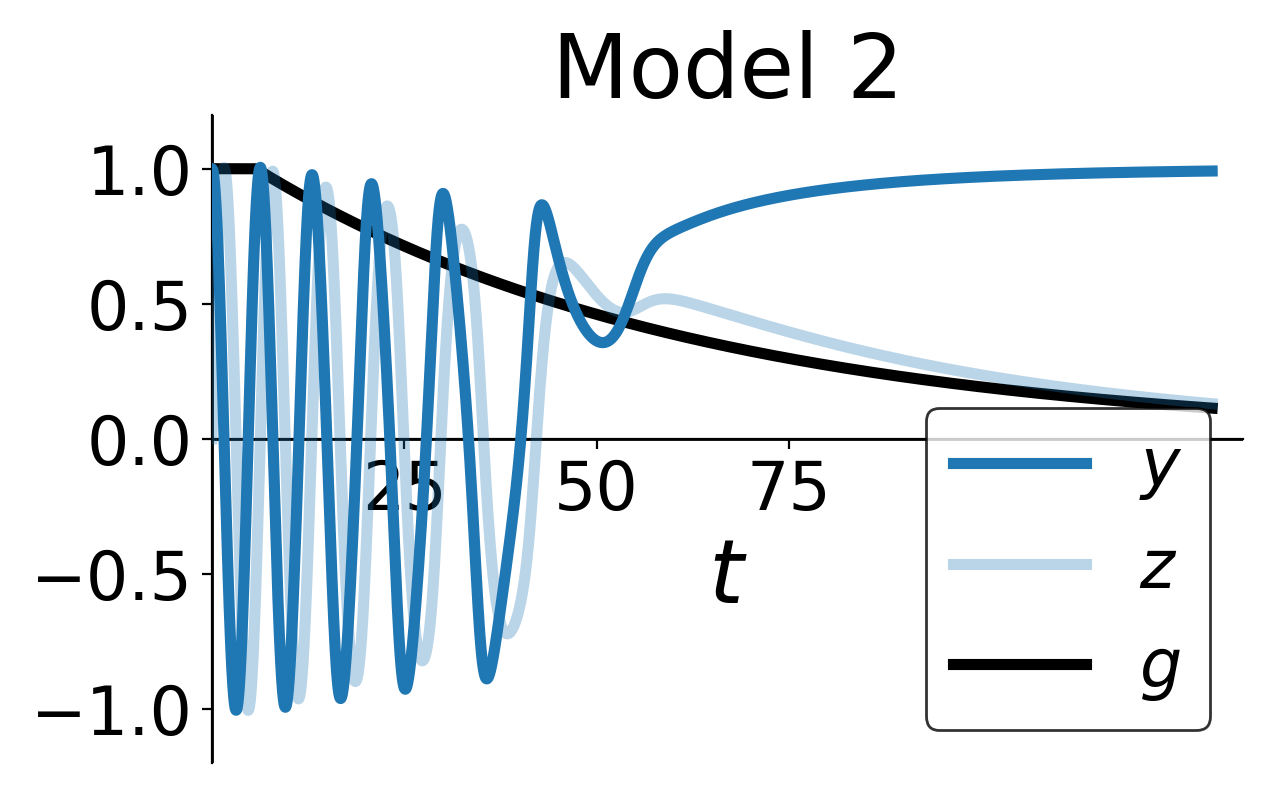

In [7]:
# Gene-free model with a Hopf bifurcation (Model 1)
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_Hopf, results_Hopf[:,0,0], c='tab:blue', lw=4, label='$y$', zorder=10)
ax.plot(times_plot_Hopf, results_Hopf[:,0,1], c='tab:blue', lw=4, alpha=0.3, label='$z$', zorder=9)
ax.plot(times_plot_Hopf, g_gradient_Hopf[:,0], c='k', lw=4, label='$g$', zorder=8)

# Move bottom x-axis to center, and eliminate upper and right axes
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Other plot options
ax.set_title('Model 1', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylim([-1.2,1.2])
ax.set_xlim([0.,param["total_t"]+4.])
ax.axhline(linewidth=1, color='k')
ax.axvline(linewidth=1, color='k')
ax.set_yticks([-1., -0.5, 0., 0.5, 1.])
ax.set_xticks([25., 50., 75., 100., 125.])
ax.tick_params(labelsize=24)
ax.legend(loc=1, fontsize=24, edgecolor='k').set_zorder(20)

fig.tight_layout()
fig.show()



# Gene-free model with a SNIC bifurcation (Model 2)
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_SNIC, results_SNIC[:,0,0], c='tab:blue', lw=4, label='$y$', zorder=10)
ax.plot(times_plot_SNIC, results_SNIC[:,0,1], c='tab:blue', lw=4, alpha=0.3, label='$z$', zorder=9)
ax.plot(times_plot_SNIC, g_gradient_SNIC[:,0], c='k', lw=4, label='$g$', zorder=8)

# Move bottom x-axis to center, and eliminate upper and right axes
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Other plot options
ax.set_title('Model 2', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylim([-1.2,1.2])
ax.set_xlim([0.,param["total_t"]+4.])
ax.axhline(linewidth=1, color='k')
ax.axvline(linewidth=1, color='k')
ax.set_yticks([-1., -0.5, 0., 0.5, 1.])
ax.set_xticks([25., 50., 75.])
ax.tick_params(labelsize=24)
ax.legend(loc=4, fontsize=24, edgecolor='k').set_zorder(20)

fig.tight_layout()
fig.show()

####   

In the next code cell, we generate a kymograph showing the spatio-temporal profile of $g$.

<IPython.core.display.Javascript object>


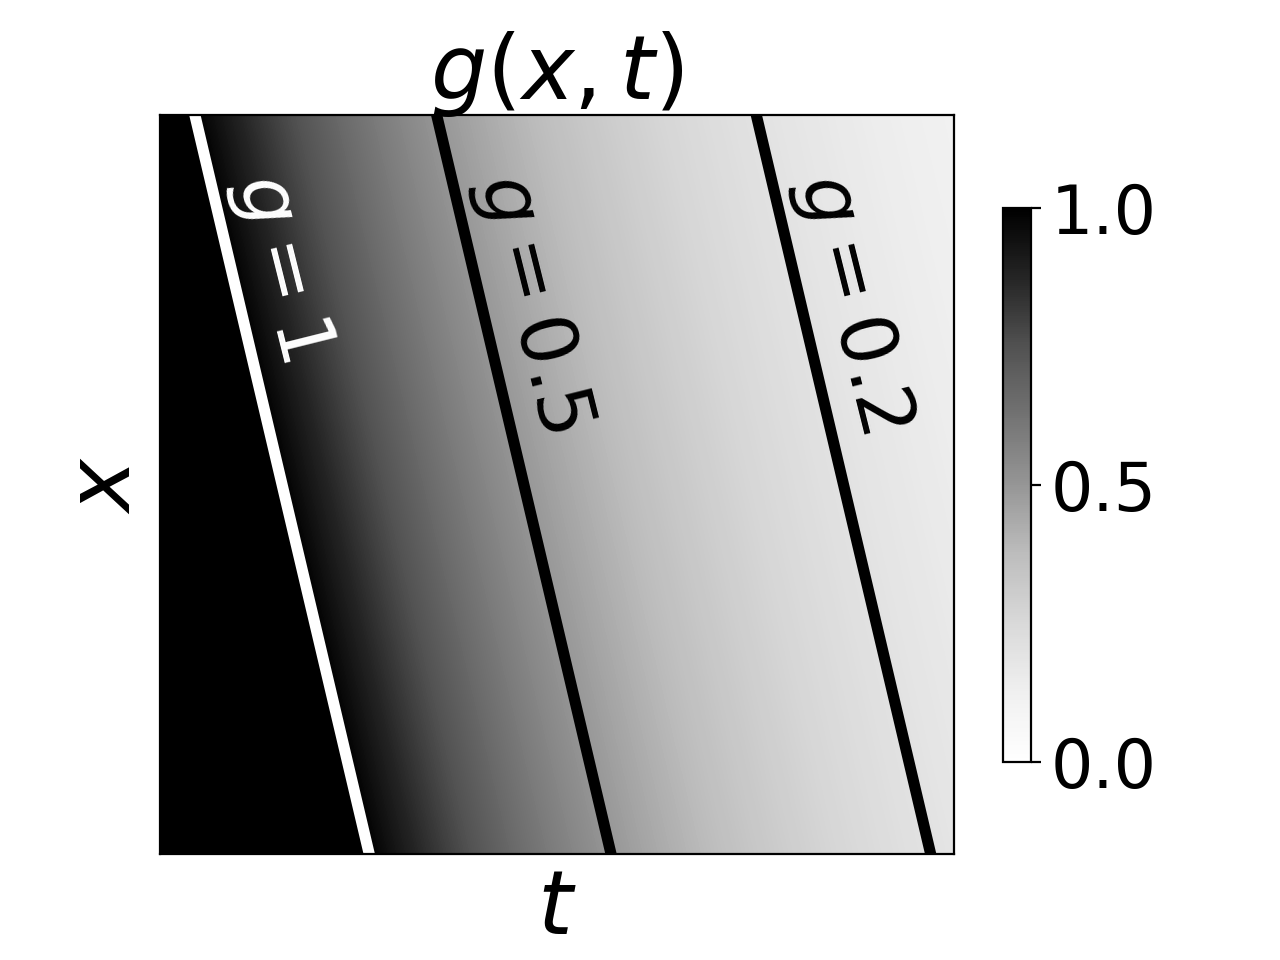

In [8]:
# Generate the kymograph of g
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(g_gradient_Hopf.transpose(), norm=norm, cmap='Greys', aspect='auto')
    
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
    
# Lines of constant g
ax.plot(param["n_cells"]*compute_x(1., times_plot_Hopf, param), color='w', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.5, times_plot_Hopf, param), color='k', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.2, times_plot_Hopf, param), color='k', linewidth=4)
    
ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=1$', color='w', rotation=-76, fontsize=28)
ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.5$', color='k', rotation=-76, fontsize=28)
ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.2$', color='k', rotation=-76, fontsize=28)
    
# Other plot options
ax.set_title('$g(x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

####   

In the following code cell, we visualise the weights of the dynamic and static modules for both versions of the gene-free model.

<IPython.core.display.Javascript object>


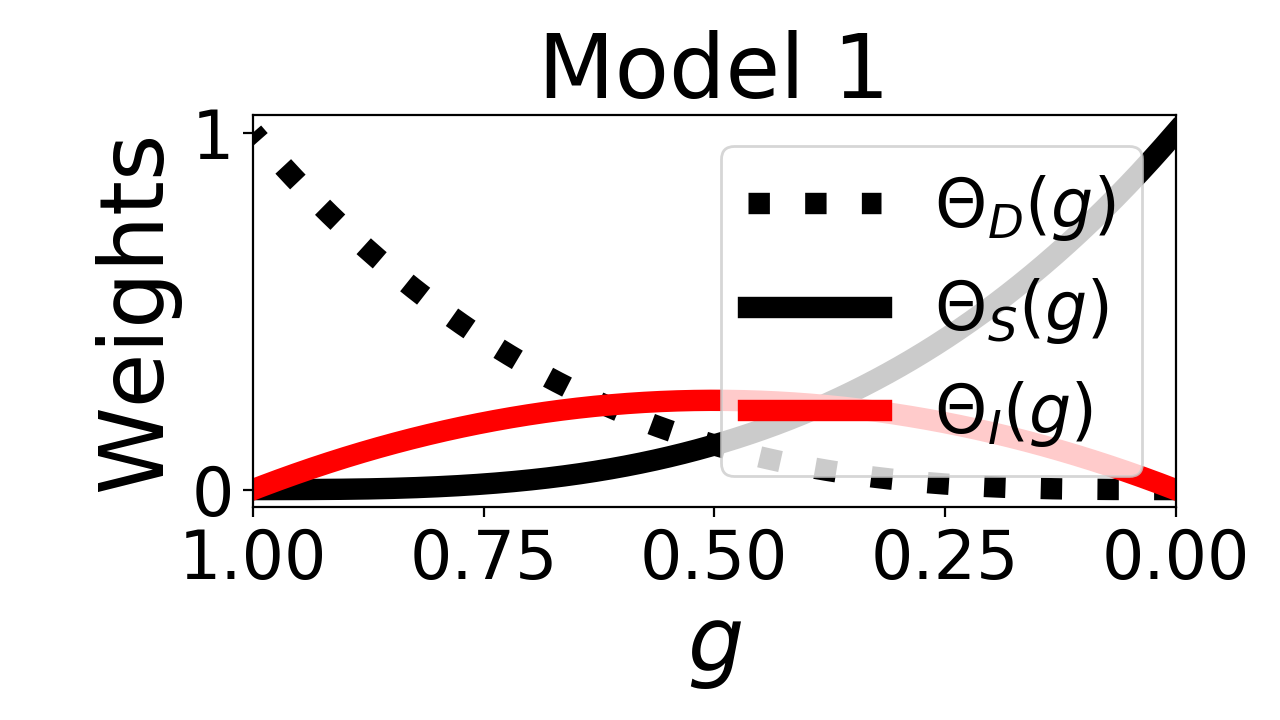

<IPython.core.display.Javascript object>


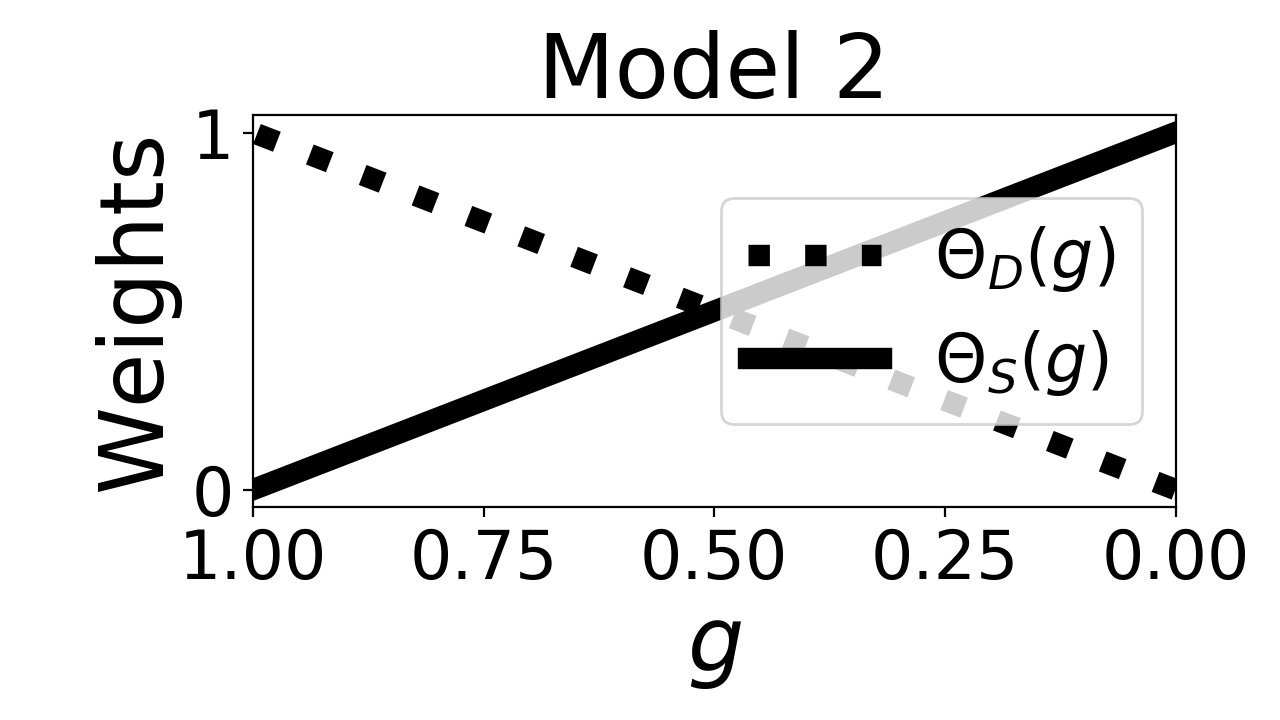

In [9]:
g_array = np.arange(0., 1.001, 0.001)

# Gene-free model with a Hopf bifurcation (Model 1)
plt.rcParams["figure.figsize"] = 6.4, 3.6
fig, ax = plt.subplots()

# Weights
g = np.arange(0., 1.001, 0.001)
ax.plot(g_array, g_array**3, c='k', ls=':', lw=7.7, label='$\Theta_D(g)$')
ax.plot(g_array, (1.-g_array)**3, c='k', ls='-', lw=7.7, label='$\Theta_S(g)$')
ax.plot(g_array, g_array*(1.-g_array), c='r', ls='-', lw=7.7, label='$\Theta_I(g)$')

# Plot options
ax.set_title('Model 1', fontsize=32)
ax.set_xlim([1., 0.])
ax.set_xlabel('$g$', fontsize=32)
ax.set_ylabel('Weights', fontsize=32)
ax.tick_params(labelsize=24)
ax.legend(fontsize=24, loc=5).set_zorder(20)

fig.tight_layout()
fig.show()



# Gene-free model with a SNIC bifurcation (Model 2)
plt.rcParams["figure.figsize"] = 6.4, 3.6
fig, ax = plt.subplots()

# Weights
g = np.arange(0., 1.001, 0.001)
ax.plot(g_array, g_array, c='k', ls=':', lw=7.7, label='$\Theta_D(g)$')
ax.plot(g_array, (1.-g_array), c='k', ls='-', lw=7.7, label='$\Theta_S(g)$')

# Plot options
ax.set_title('Model 2', fontsize=32)
ax.set_xlim([1., 0.])
ax.set_xlabel('$g$', fontsize=32)
ax.set_ylabel('Weights', fontsize=32)
ax.tick_params(labelsize=24)
ax.legend(fontsize=24, loc=5).set_zorder(20)

fig.tight_layout()
fig.show()

####    

**2. Bifurcation diagrams**

For both versions of the gene-free model, we generate a bifurcation diagram that shows the position in phase space of the fixed points and limit cycles as a function of parameter $g$. We plot the values of $y$ at which stable and unstable fixed points can be found, as well as the minimum and maximum values of $y$ that are reached by the oscillations on the limit cycle. The XPP AUTO software was used to generate the data plotted on these bifurcation diagams. The `.dat` data files, as well as the `.ode` files used to generate the data can be found in the `XPPAUTO_data` folder.


####   

**2.1 Extracting the fixed points and limit cycles**

We first define functions that extract the data obtained with the XPP AUTO software. The function `extract_fixed_pts` outputs a matrix containing information about the position of the fixed points in the data file and an array of colors for the fixed points, either green for a stable fixed point or red for an unstable fixed point. Similarly, the function `extract_limit_cycles` assigns a color to each limit cycle in the data file, either grey for a stable cycle or blue for an unstable cycle.

In [10]:
def extract_fixed_pts(data_file):
    
    fixed_pts = np.genfromtxt(data_file, delimiter=' ')

    fixed_pts_color = []
    for fps in fixed_pts[:,0]:
    
        if (int(fps) == 1):    fixed_pts_color.append('tab:green')
        elif (int(fps) == 2):    fixed_pts_color.append('tab:red')
        else:
            print('ERROR: one of the points is neither a stable nor unstable equilibria.')
            break
            
    return fixed_pts, fixed_pts_color

        

def extract_limit_cycles(data_file):
    
    limit_cycles = np.genfromtxt(data_file, delimiter=' ')

    limit_cycles_color = []
    for lc in limit_cycles[:,0]:
    
        if (int(lc) == 3):    limit_cycles_color.append('tab:grey')
        elif (int(lc) == 4):    limit_cycles_color.append('tab:blue')
        else:
            print('ERROR: one of the points is neither stable nor unstable periodics.')
            break
            
    return limit_cycles, limit_cycles_color

####   

**2.2 Generating the bifurcation diagrams**

We plot the bifurcation diagrams, and indicate the bifurcation events that occur in each model.

<IPython.core.display.Javascript object>


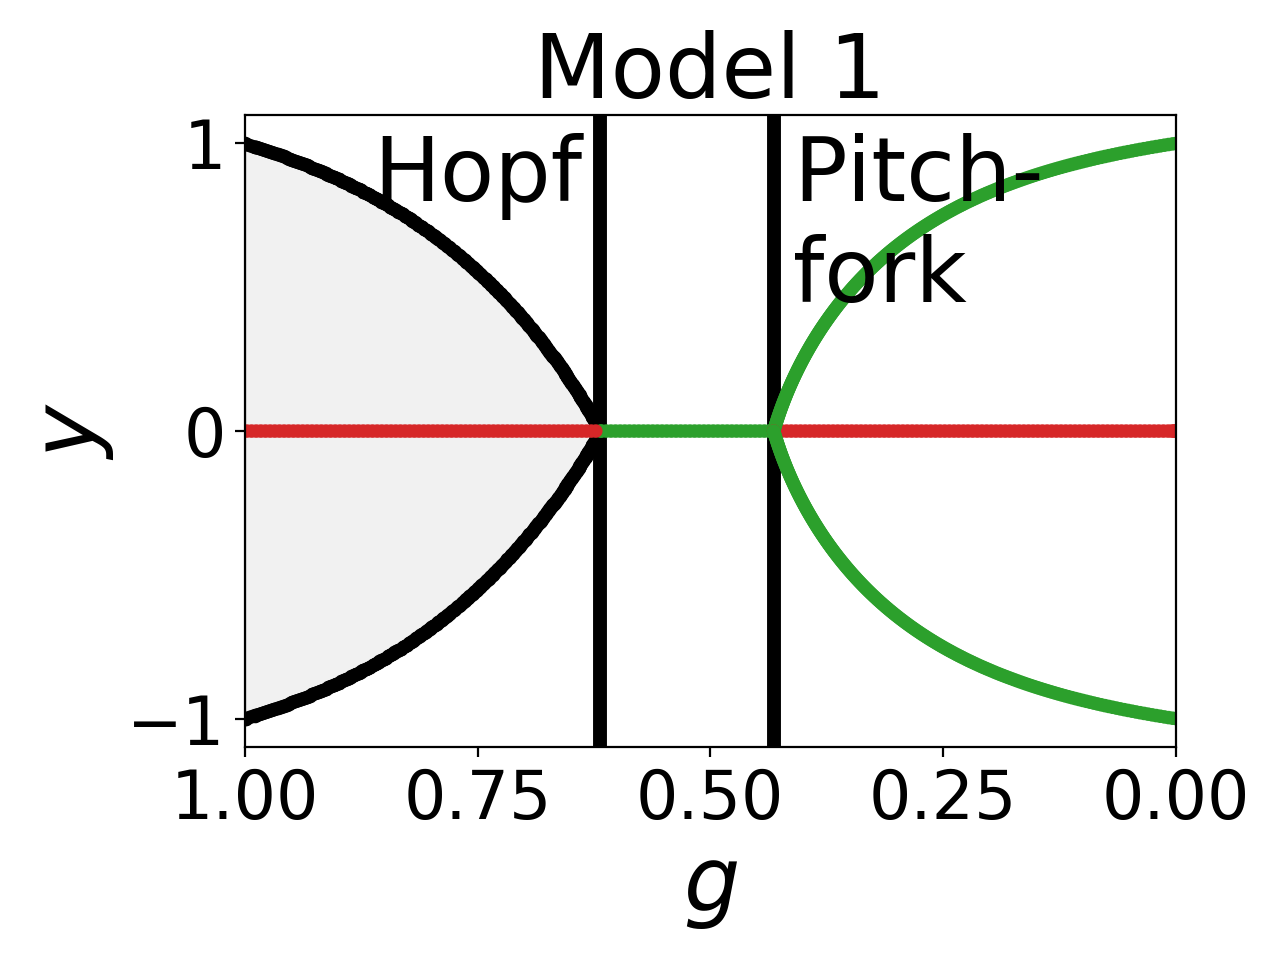

In [11]:
# Gene-free model with a Hopf bifurcation (Model 1)

# Extract the data
fp_Hopf, fp_Hopf_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_m1_fp.dat')
lc_Hopf, lc_Hopf_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_m1_lc.dat')
g_Hopf = 0.618
g_SN = 0.431

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_Hopf[:220,3], lc_Hopf[:220,6], lc_Hopf[:220,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_Hopf[:,3], lc_Hopf[:,6], s=15, color='k')
ax.scatter(lc_Hopf[:,3], lc_Hopf[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_Hopf[:,3], fp_Hopf[:,6], s=15, color=fp_Hopf_color)

# Bifurcations
ax.plot([g_Hopf, g_Hopf], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_Hopf+0.02, 0.8, 'Hopf', fontsize=32, horizontalalignment='right')
ax.plot([g_SN, g_SN], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_SN-0.02, 0.8, 'Pitch-', fontsize=32, horizontalalignment='left')
ax.text(g_SN-0.02, 0.45, 'fork', fontsize=32, horizontalalignment='left')
    
# Other plot options
ax.set_title('Model 1', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-1.1, 1.1])
ax.set_yticks([-1., 0., 1.])
        
fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


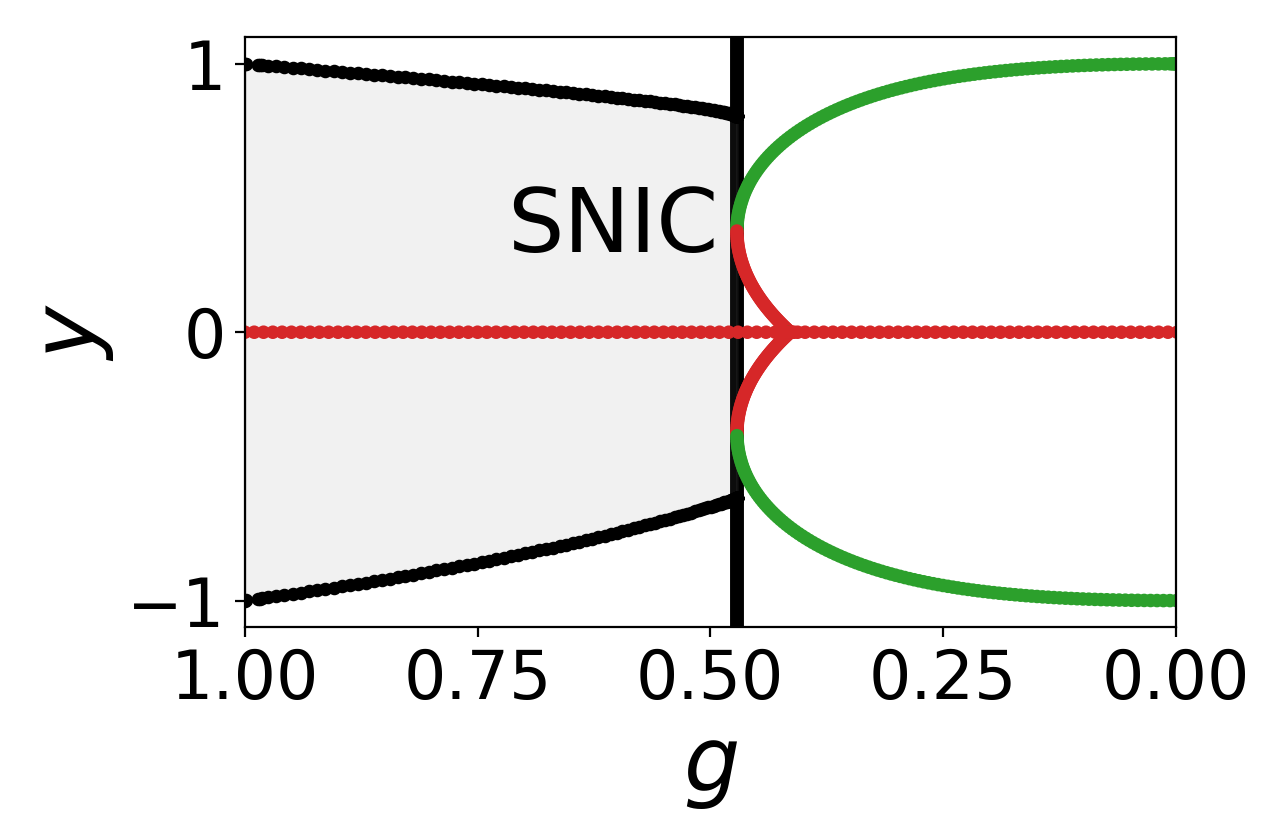

In [12]:
# Gene-free model with a SNIC bifurcation (Model 2)

# Extract the data
fp_SNIC, fp_SNIC_color = extract_fixed_pts('XPPAUTO_data/Gene-free_models/Gene-free_m2_fp.dat')
lc_SNIC, lc_SNIC_color = extract_limit_cycles('XPPAUTO_data/Gene-free_models/Gene-free_m2_lc.dat')
g_SNIC = 0.471

# Plot the bifurcation diagram
plt.rcParams["figure.figsize"] = 6.4, 4.2
fig, ax = plt.subplots()

# Limit cycles
ax.fill_between(lc_SNIC[:,3], lc_SNIC[:,6], lc_SNIC[:,9], color='tab:grey', alpha=0.1)
ax.scatter(lc_SNIC[:,3], lc_SNIC[:,6], s=15, color='k')
ax.scatter(lc_SNIC[:,3], lc_SNIC[:,9], s=15, color='k')

# Fixed points
ax.scatter(fp_SNIC[:,3], fp_SNIC[:,6], s=15, color=fp_SNIC_color)

# Bifurcations
ax.plot([g_SNIC, g_SNIC], [-1.1, 1.1], 'k', lw=5, zorder=0)
ax.text(g_SNIC+0.02, 0.3, 'SNIC', fontsize=32, horizontalalignment='right')
    
# Other plot options
# ax.set_title('Model 2', fontsize=32)
ax.set_ylabel('$y$', fontsize=32)
ax.set_xlabel('$g$', fontsize=32)
ax.tick_params(labelsize=24)
ax.set_xlim([1., 0.])
ax.set_ylim([-1.1, 1.1])
        
fig.tight_layout()
fig.show()

####    

**2.3 Period and amplitude dependence on the control parameter**

In this section of the notebook, we plot the period and the amplitude as a function of $g$ for the two versions of the gene-free model. Again, the data is obtained with the XPP AUTO software.

Before generating the plots, we define a function that extracts the minimum and maximum $y$ and $z$ values reached by the oscillations on the stable limit cycles and computes the amplitude. This function also extracts the period of the oscillations on the stable limit cycle. This function takes as an input the `.dat` files obtained with XPP AUTO.

In [13]:
def extract_period_amplitude(data_file):
    
    data = np.genfromtxt(data_file, delimiter=' ')
    
    g = data[:,3]
    T = data[:,5]
    
    max_x = data[:,6]
    max_y = data[:,7]
    min_x = data[:,8]
    min_y = data[:,9]
    
    A_x = max_x -min_x
    A_y = max_y -min_y
    
    return np.array([g, T, A_x, A_y])

<IPython.core.display.Javascript object>


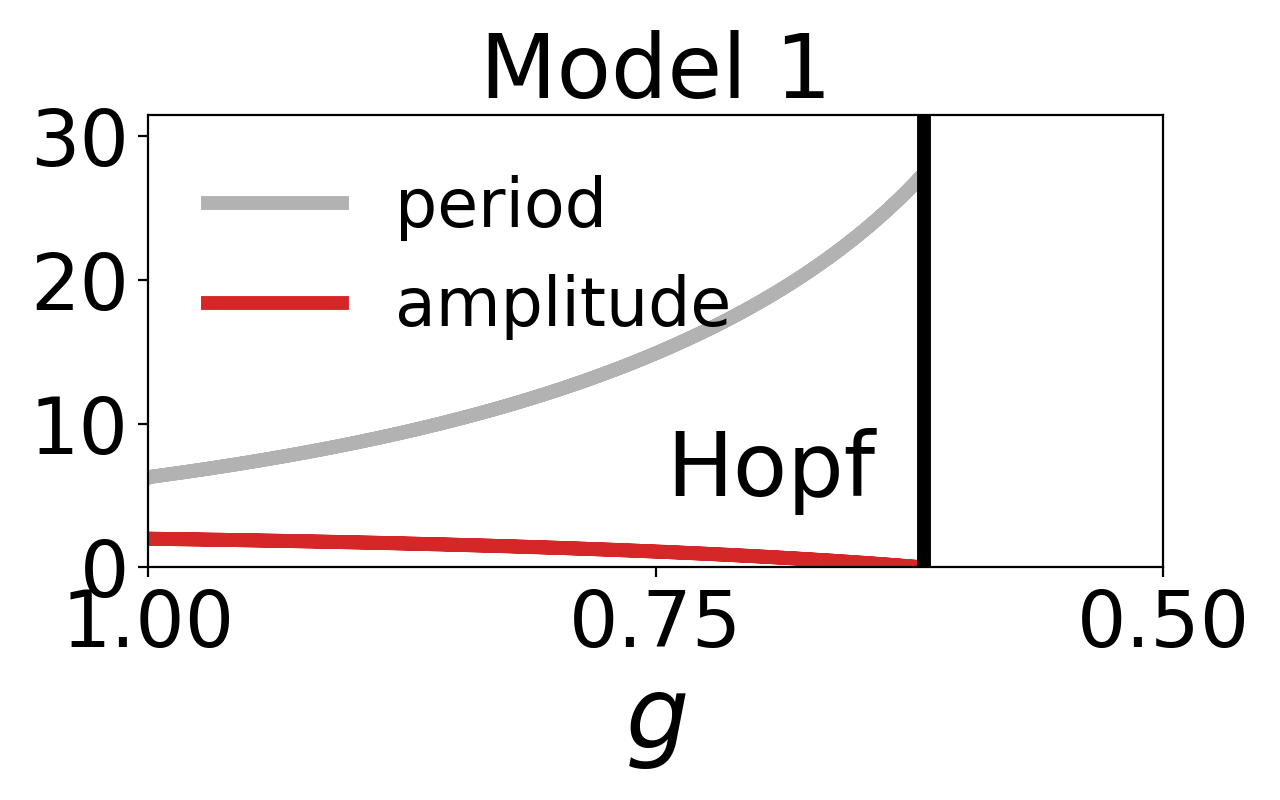

In [14]:
# Gene-free model with a Hopf bifurcation (Model 1)
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Extract the Data
Hopf_period_amplitude = extract_period_amplitude('XPPAUTO_data/Gene-free_models/Gene-free_m1_lc.dat')

# Plot the period and the amplitude
ax.plot(Hopf_period_amplitude[0], Hopf_period_amplitude[1], c='k', alpha=0.3, lw=5)
ax.plot(Hopf_period_amplitude[0], Hopf_period_amplitude[2], c='tab:red', lw=5)

# Identify the Hopf bifurcation
ax.plot([g_Hopf, g_Hopf], [0., 31.], c='k', ls='-', lw=5)
ax.text(0.745, 5., 'Hopf', fontsize=32)

# Generate the legend
ax.plot([], c='k', alpha=0.3, lw=5, label='period')
ax.plot([], c='tab:red', lw=5, label='amplitude')
legend = ax.legend(loc=2, fontsize=24, frameon=False)

# Other plot options
ax.set_title('Model 1', fontsize=32)
ax.tick_params(labelsize=28)
ax.set_xlim([1., 0.5])
ax.set_ylim([0., 31.5])
ax.set_yticks([0., 10., 20., 30.])
ax.set_xticks([1., 0.75, 0.5])
ax.set_xlabel('$g$', fontsize=36)

fig.tight_layout()
fig.show()

<IPython.core.display.Javascript object>


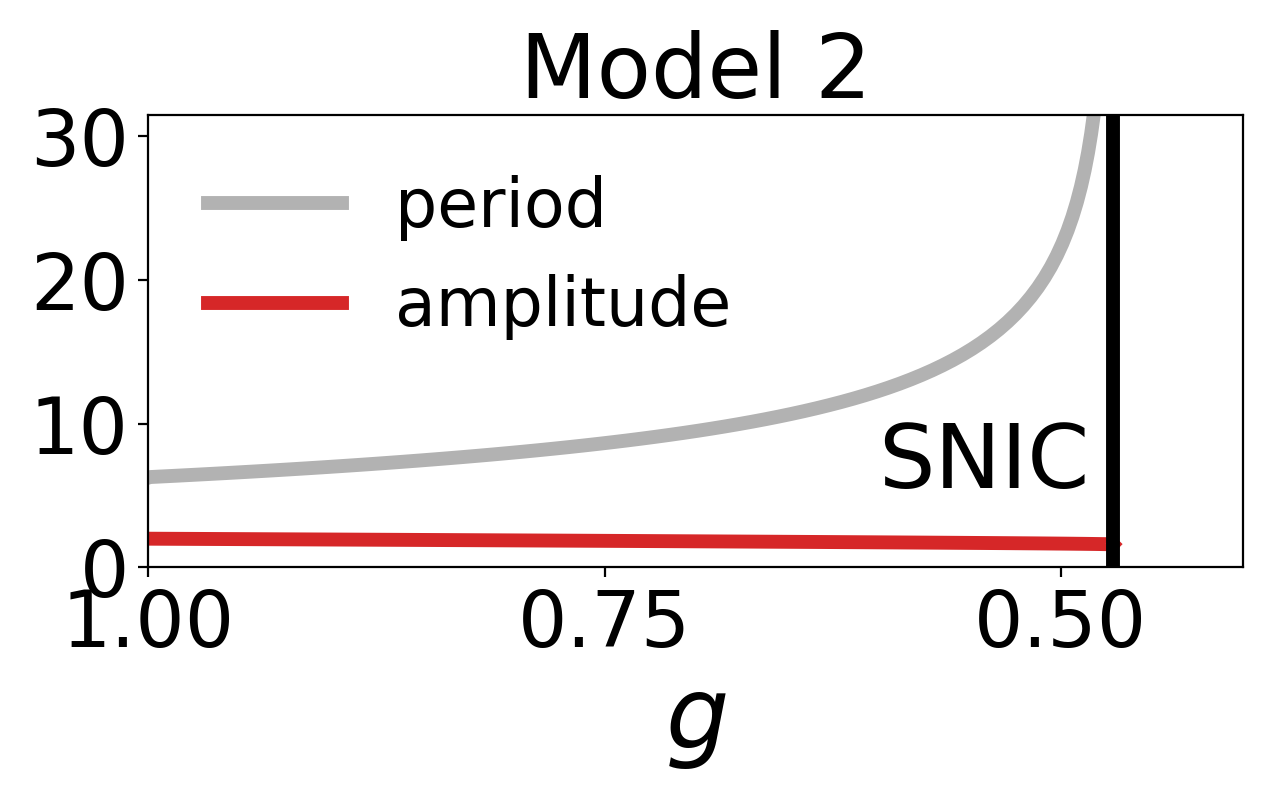

In [15]:
# Gene-free model with a SNIC bifurcation (Model 2)
plt.rcParams["figure.figsize"] = 6.4, 4.
fig, ax = plt.subplots()

# Extract the data
SNIC_period_amplitude = extract_period_amplitude('XPPAUTO_data/Gene-free_models/Gene-free_m2_lc.dat')

# Plot the period and the amplitude
ax.plot(SNIC_period_amplitude[0], SNIC_period_amplitude[1], c='k', alpha=0.3, lw=5)
ax.plot(SNIC_period_amplitude[0], SNIC_period_amplitude[2], c='tab:red', lw=5)

# Identify the SNIC bifurcation
ax.plot([g_SNIC, g_SNIC], [0., 31.], c='k', ls='-', lw=5)
ax.text(0.6, 5.5, 'SNIC', fontsize=32)

# Generate the legend
ax.plot([], c='k', alpha=0.3, lw=5, label='period')
ax.plot([], c='tab:red', lw=5, label='amplitude')
legend = ax.legend(fontsize=24, frameon=False)

# Other plot options
ax.set_title('Model 2', fontsize=32)
ax.tick_params(labelsize=28)
ax.set_xlim([1., 0.4])
ax.set_ylim([0., 31.5])
ax.set_yticks([0., 10., 20., 30.])
ax.set_xticks([1., 0.75, 0.5])
ax.set_xlabel('$g$', fontsize=36)

fig.tight_layout()
fig.show()

As the system approaches the Hopf bifurcation in Model 1, the amplitude smoothly reaches 0, and the oscillations die with a finite period, as expected. Conversely, as the system approaches the SNIC bifurcation in Model 2, the amplitude stays non-zero and the period smoothly reaches infinity, as expected.


####   

**3. Flow plots**

One advantage of working with 2D models is that we can plot the flow in phase space on 2D diagrams. This allows us to visualise how different bifurcation events affect the geometry of phase space in different ways.

On each flow plot, we represent the flow with thin black arrows. We also plot the $y$ and $z$ nullclines with orange and yellow lines, respectively. The $y$ (resp. $z$) nullcline is the solution to the equation obtained by setting the derivative of $y$ (resp. $z$) to 0 in the ODEs. The fixed points of the system are found at the positions where the nullclines meet. We represent stable fixed points with green dots, and unstable fixed points with red dots. Lastly, we represent stable limit cycles with grey lines, and visualise the speed along the cycle by representing positions separated by a fixed time interval as small black dots.


####    

**3.1 Redefining the ODEs**

To get the flow and the nullclines, we will use the `matplotlib` functions `streamplot` and `contour`. These functions require that we define the ODEs for the $y$ and $z$ components in separate functions. We also define a function that returns the derivative of the whole system (i.e. of both the $y$ and $z$ components) in the specific format required to use the `scipy` function `odeint`. This function will be used to determine the positions along the limit cycles for different values of $g$.

In [16]:
def dy(y, z, g, param):
    
    ng = param["ng"]
    if_interm= param["if_interm"]
    r = np.sqrt(y*y +z*z)
    
    return g**ng*(y*(1.-r) -z) +(1.-g)**ng*y*(1.-y*y) -if_interm*g*(1.-g)*y


def dz(y, z, g, param):
    
    ng = param["ng"]
    if_interm= param["if_interm"]
    r = np.sqrt(y*y +z*z)
    
    return g**ng*(z*(1.-r) +y) -(1.-g)**ng*z -if_interm*g*(1.-g)*z


def dvec2(vec, t, g, param):
    
    y, z = vec
    
    return dy(y, z, g, param), dz(y, z, g, param)

####    

**3.2 Extracting the limit cycles**

The XPP AUTO software only outputs the minimum and maximum values of the $x$ and $y$ components along the limit cycles. To draw the full cycles on the flow plots, we need the entire time courses. We therefore integrate the ODEs for all values of $g$ between 0 and 1 (with an increment of 0.001) and store the results in the `cycle_Hopf` and `cycle_SNIC` lists.

In [17]:
g_array = np.arange(0., 1.001, 0.001)
times = np.arange(0., 250., 0.01)


# Gene-free model with a Hopf bifurcation (Model 1)
param["ng"] = 3
param["if_interm"] = 1.
cycle_Hopf = []
init_cond = [1.0, 0.0]

for k in range(len(g_array)):
    
    cycle_Hopf.append(odeint(dvec2, init_cond, times, args=(g_array[-k-1], param)))
    init_cond = cycle_Hopf[-1][-1]
    cycle_Hopf[-1] = cycle_Hopf[-1].transpose()

cycle_Hopf = list(reversed(cycle_Hopf))



# Gene-free model with a SNIC bifurcation (Model 2)
param["ng"] = 1
param["if_interm"] = 0.
cycle_SNIC = []
init_cond = [1.0, 0.0]

for k in range(len(g_array)):
    
    cycle_SNIC.append(odeint(dvec2, init_cond, times, args=(g_array[-k-1], param)))
    init_cond = cycle_SNIC[-1][-1]
    cycle_SNIC[-1] = cycle_SNIC[-1].transpose()

cycle_SNIC = list(reversed(cycle_SNIC))

####    

**3.3 Extracting the fixed points**

It is not possible to control precisely at which values of $g$ the XPPAUTO software will evaluate the positions of the fixed points. To make sure that we have the positions of the fixed points at the same values of $g$ at which we determined the positions along the limit cycle, we determined the positions of the fixed points using Mathematica. The Mathematica notebook is included in the `MATHEMATICA_DATA` folder. Since our Mathematica code only outputs the positions of the fixed points, we need to manually determine their stability. This is achieved with the function `test_stability_fixed_pt` defined below.

In [18]:
def test_stability_fixed_pt(y, z, g, param):
    
    times_test_stability = np.arange(0.0, 400.0, 0.1)
    traj = odeint(dvec2, [y+1e-3, z+1e-3], times_test_stability, args=(g, param))
    
    if (abs(traj[-1,0]-y) < 1e-3) & (abs(traj[-1,1]-z) < 1e-3):
        test_stable = True
    
    else:    test_stable = False
    
    return test_stable

In [19]:
# Gene-free model with a Hopf bifurcation (Model 1) 
param["ng"] = 3
param["if_interm"] = 1.
fixed_pts_Hopf = [[] for j in range(len(g_array))]

fixed_pts_temp = np.genfromtxt("Mathematica_data/Gene-free_m1_fp.txt", delimiter='	')
counter = 0

# Extract the data
for k in range(len(fixed_pts_temp)):
    
    if (fixed_pts_temp[k,0] != fixed_pts_temp[k-1,0]) and (k != 0):
        counter += 1
    
    fixed_pts_Hopf[counter].append(fixed_pts_temp[k,1:])


# Determine the stability of the fixed points   
fixed_pts_Hopf_color = [[] for k in range(len(fixed_pts_Hopf))]

for k in range(len(fixed_pts_Hopf)):

    for j in range(len(fixed_pts_Hopf[k])):
        
        if test_stability_fixed_pt(fixed_pts_Hopf[k][j][0], fixed_pts_Hopf[k][j][1], g_array[k], param):
            fixed_pts_Hopf_color[k].append('tab:green')
                   
        else:
            fixed_pts_Hopf_color[k].append('tab:red')

In [20]:
# Gene-free model with a SNIC bifurcation (Model 2) 
param["ng"] = 1
param["if_interm"] = 0.
fixed_pts_SNIC = [[] for j in range(len(g_array))]

fixed_pts_temp = np.genfromtxt("Mathematica_data/Gene-free_m2_fp.txt", delimiter='	')
counter = 0

# Extract the data
for k in range(len(fixed_pts_temp)):
    
    if (fixed_pts_temp[k,0] != fixed_pts_temp[k-1,0]) and (k != 0):
        counter += 1
    
    fixed_pts_SNIC[counter].append(fixed_pts_temp[k,1:])


# Determine the stability of the fixed points   
fixed_pts_SNIC_color = [[] for k in range(len(fixed_pts_SNIC))]

for k in range(len(fixed_pts_SNIC)):

    for j in range(len(fixed_pts_SNIC[k])):
        
        if test_stability_fixed_pt(fixed_pts_SNIC[k][j][0], fixed_pts_SNIC[k][j][1], g_array[k], param):
            fixed_pts_SNIC_color[k].append('tab:green')
                   
        else:
            fixed_pts_SNIC_color[k].append('tab:red')

####  

**3.4 Generating the flow plots**

We first create a grid of points at which the flow and the nullclines will be determined. Then, we define a function that plots the flow for a given value of $g$ specified by the `g_index` variable. In other words, the function `plot_flow` takes as a first argument the index of the `g_array` at which can be found the specific value of $g$ for which we want to plot the flow. The specific way in which the `g_array` is constructed makes it quite straightforward to find the index at which the desired value of $g$ can be found. Indeed, $g=0.123$ can be found at the index 123, $g=0.098$ is at the index 98, and so on.

The second and third arguments of the `plot_flow` function are the list of positions of the fixed points and the list of colors for plotting the fixed points, respectively. The fourth argument is the list of positions along the limit cycles. To represent the speed along the limit cycle, we plot black dots along the cycle at positions that are equally spaced in time. In other words, we first plot all points along the cycle in grey to visualise the complete cycle. Then, we select a few points that all have the same time interval between them and plot them on top of the grey cycle as black dots. The fifth and sixth arguments of the `plot_flow` function are the time interval between points and the total number of points, repsectively. Note that this method allows us to visualise changes of speed along the limit cycle for a given value of $g$, but not to compare the speed of distinct limit cycles obtained at different values of $g$. To achieve the latter, one would need to keep the interval between points constant across flow plots at different values of $g$.

In [21]:
grid_max = 1.2
grid_min = -grid_max
grid_step = 0.01

y_grid = np.arange(grid_min, grid_max+grid_step, grid_step)
z_grid = np.arange(grid_min, grid_max+grid_step, grid_step)
Y_grid, Z_grid = np.meshgrid(y_grid, z_grid)



def plot_flow(g_index, fixed_pts, fixed_pts_color, cycle, dt_cycle, total_pts_cycle, param):
    
    
    plt.rcParams["figure.figsize"] = 6.4, 3.7
    fig, ax = plt.subplots()
    
    # Flow
    ax.streamplot(Y_grid, Z_grid, dy(Y_grid, Z_grid, g_array[g_index], param), dz(Y_grid, Z_grid, g_array[g_index], param), color='k', density=0.5, linewidth=1.2, arrowstyle='->', zorder=0)
    
    # Nullclines
    ax.contour(Y_grid, Z_grid, dy(Y_grid, Z_grid, g_array[g_index], param), levels=[0], colors='tab:orange', linewidths=4)
    ax.contour(Y_grid, Z_grid, dz(Y_grid, Z_grid, g_array[g_index], param), levels=[0], colors='gold', linewidths=4)
    
    # Limit cycles
    if (total_pts_cycle > 0):
        ax.scatter(cycle[g_index][0], cycle[g_index][1], c='gainsboro', lw=4, zorder=9)
        for k in range(total_pts_cycle):
            ax.scatter(cycle[g_index][0,k*dt_cycle], cycle[g_index][1,k*dt_cycle], c='k', lw=2, zorder=10)
    
    # Fixed points
    for j in range(len(fixed_pts[g_index])):
        ax.scatter(fixed_pts[g_index][j][0], fixed_pts[g_index][j][1], color=fixed_pts_color[g_index][j], s=400, zorder=8)

    # Plot options
    if (param["if_interm"] == 1.):    version = '1'
    else:    version = '2'
    
    ax.set_title('Model '+version+'  $[g='+str(g_index/1000.)+']$', fontsize=24)
    ax.set_xlabel('$y$', fontsize=28)
    ax.set_ylabel('$z$', fontsize=28)
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_aspect('equal')
    ax.tick_params(labelsize=20)
    
    fig.tight_layout()
    fig.show()

####   

**3.5 The flow of the gene-free model with a Hopf bifurcation**

We first visualise how the limit cycle deforms from its initial shape, i.e. from its shape in the dynamic module. Then, we plot the flow right before and after the Hopf bifurcation, as well as right before and after the pitchfork bifurcation. Finally, we visualise how the stable fixed points defining the regions of the pattern move to their final positions, i.e to their positions in the static module.

<IPython.core.display.Javascript object>


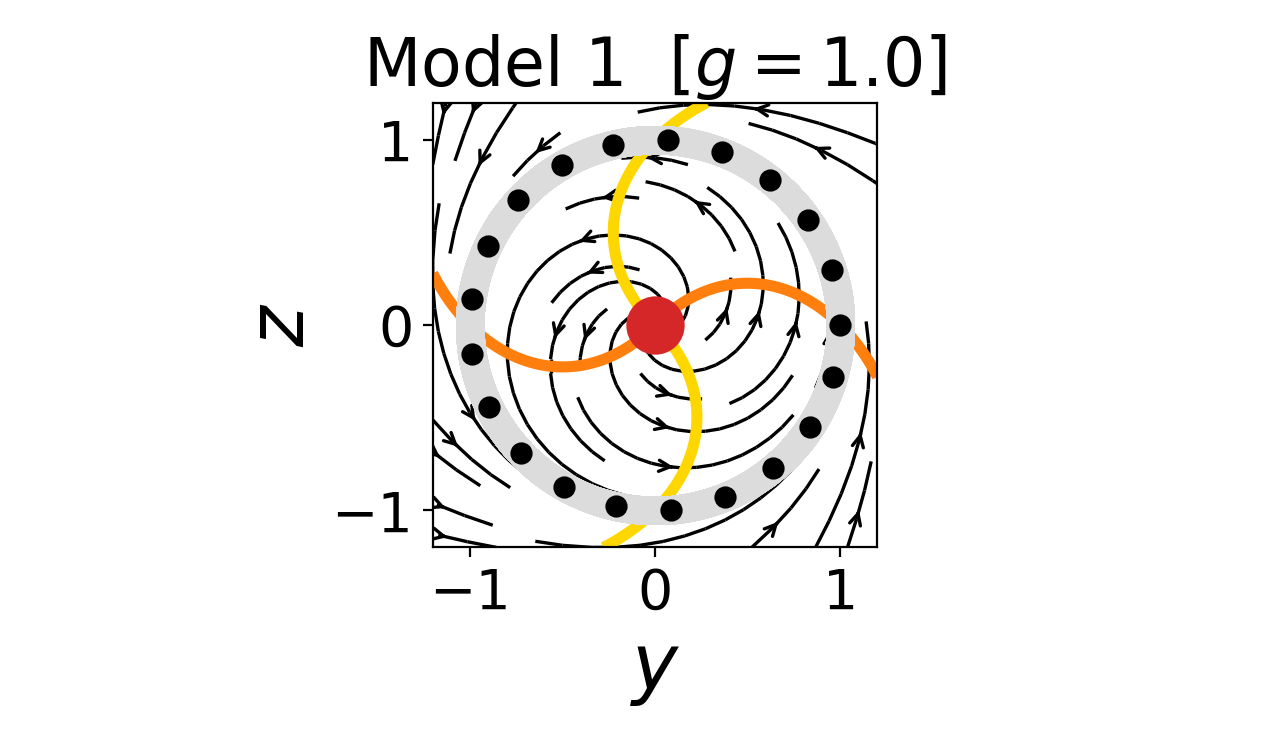

<IPython.core.display.Javascript object>


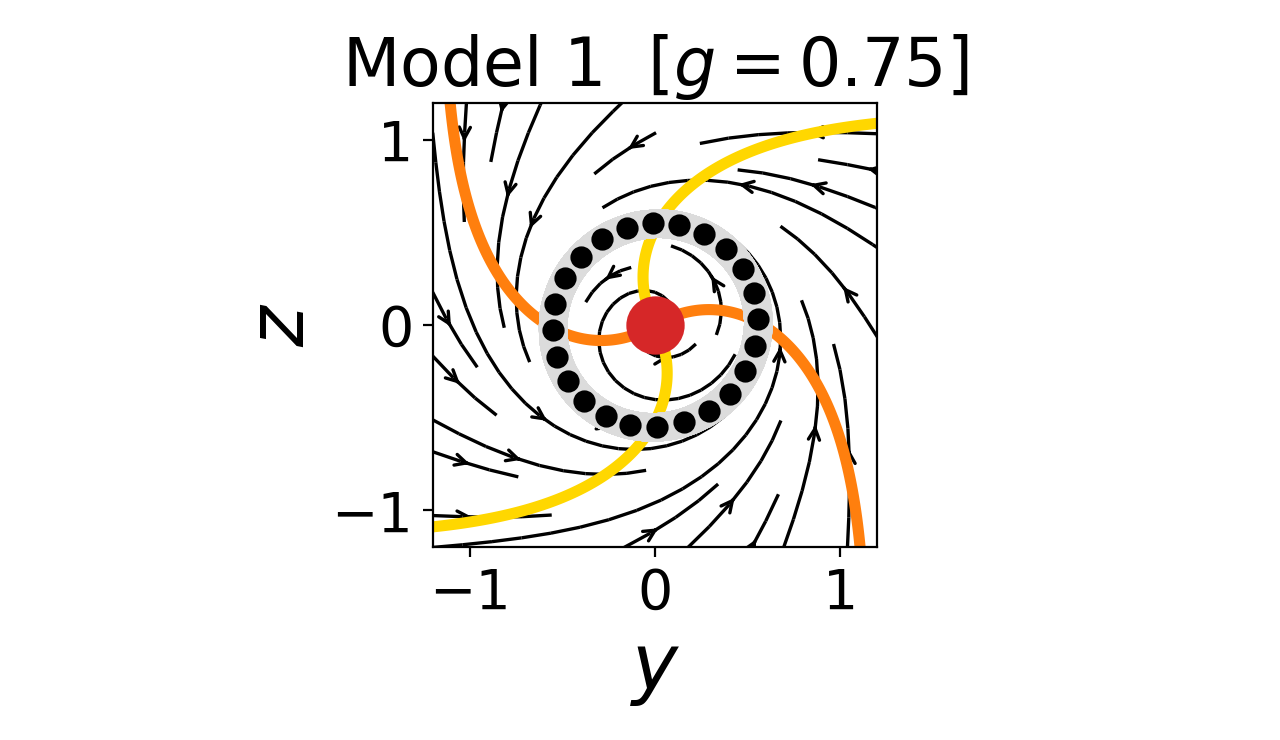

<IPython.core.display.Javascript object>


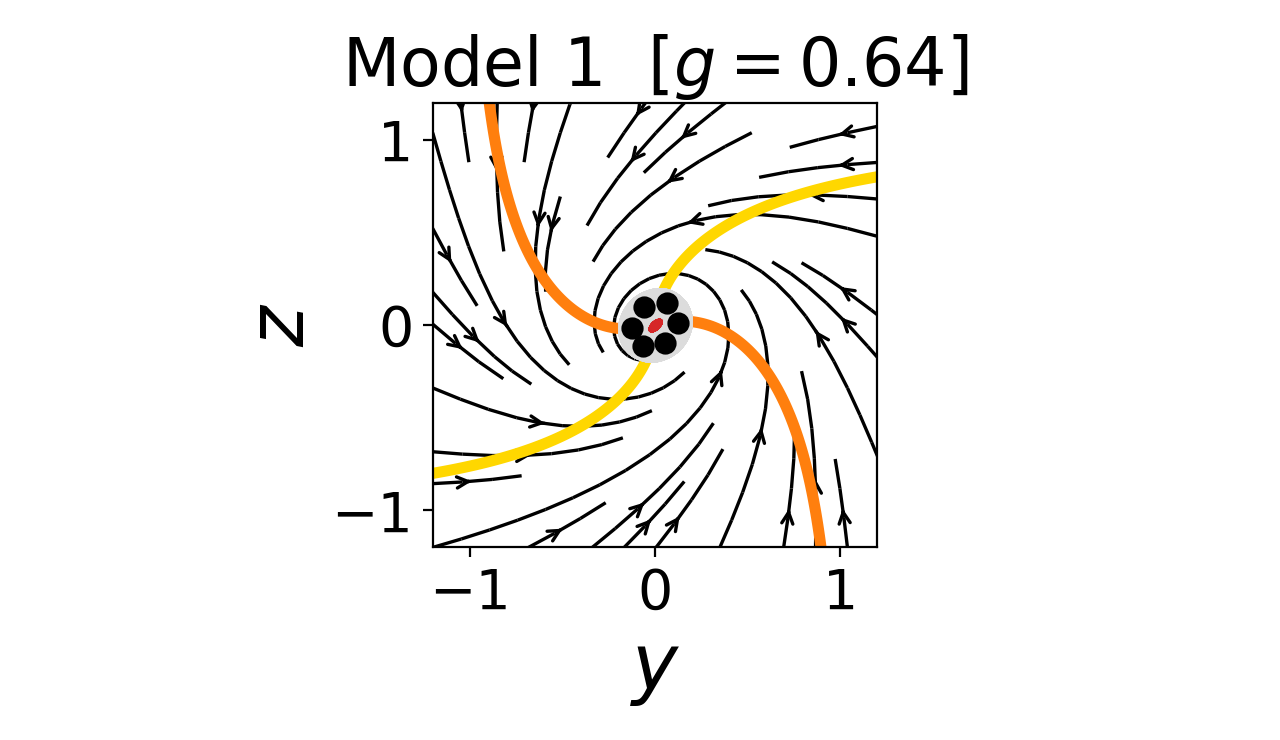

<IPython.core.display.Javascript object>


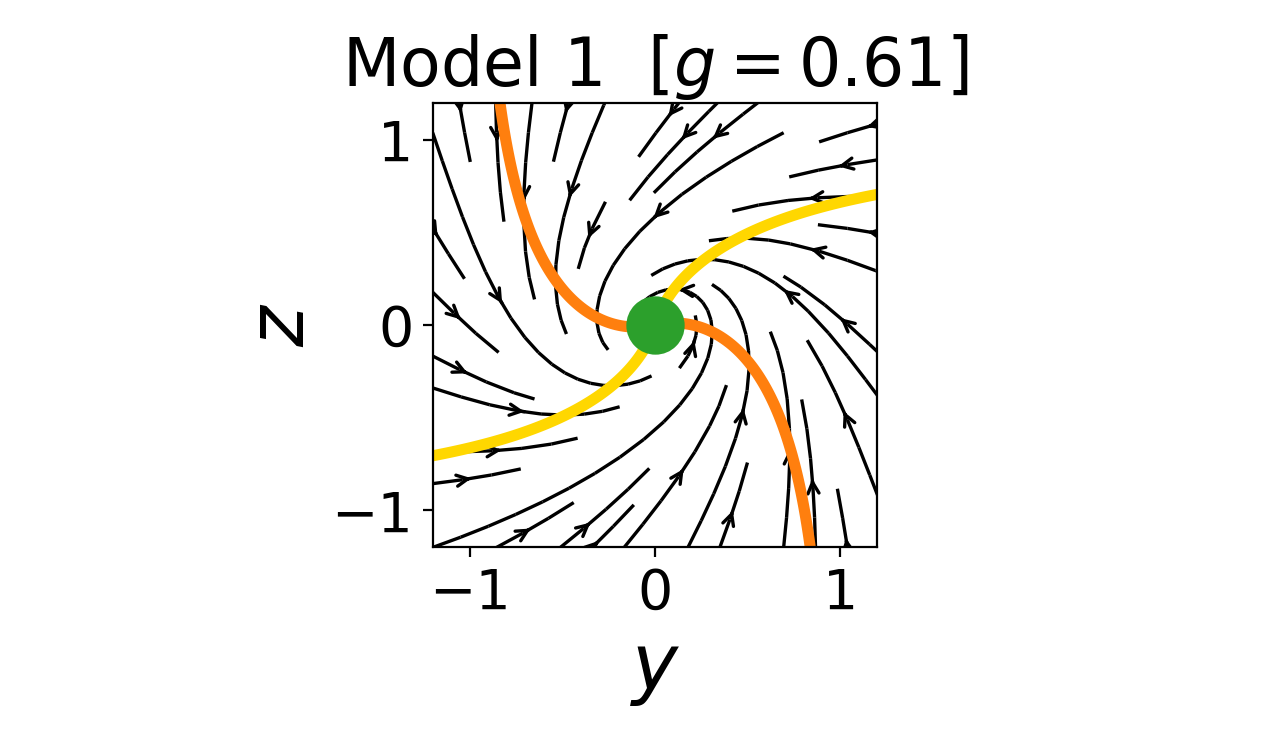

<IPython.core.display.Javascript object>


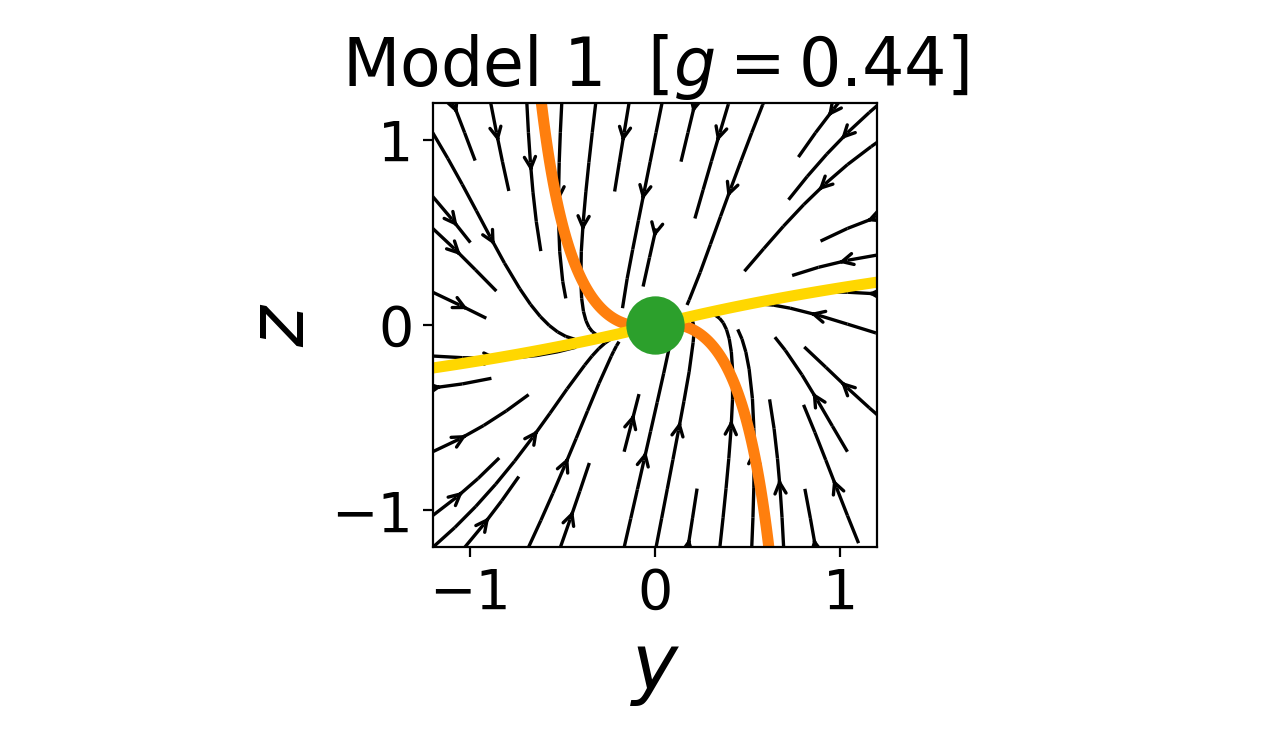

<IPython.core.display.Javascript object>


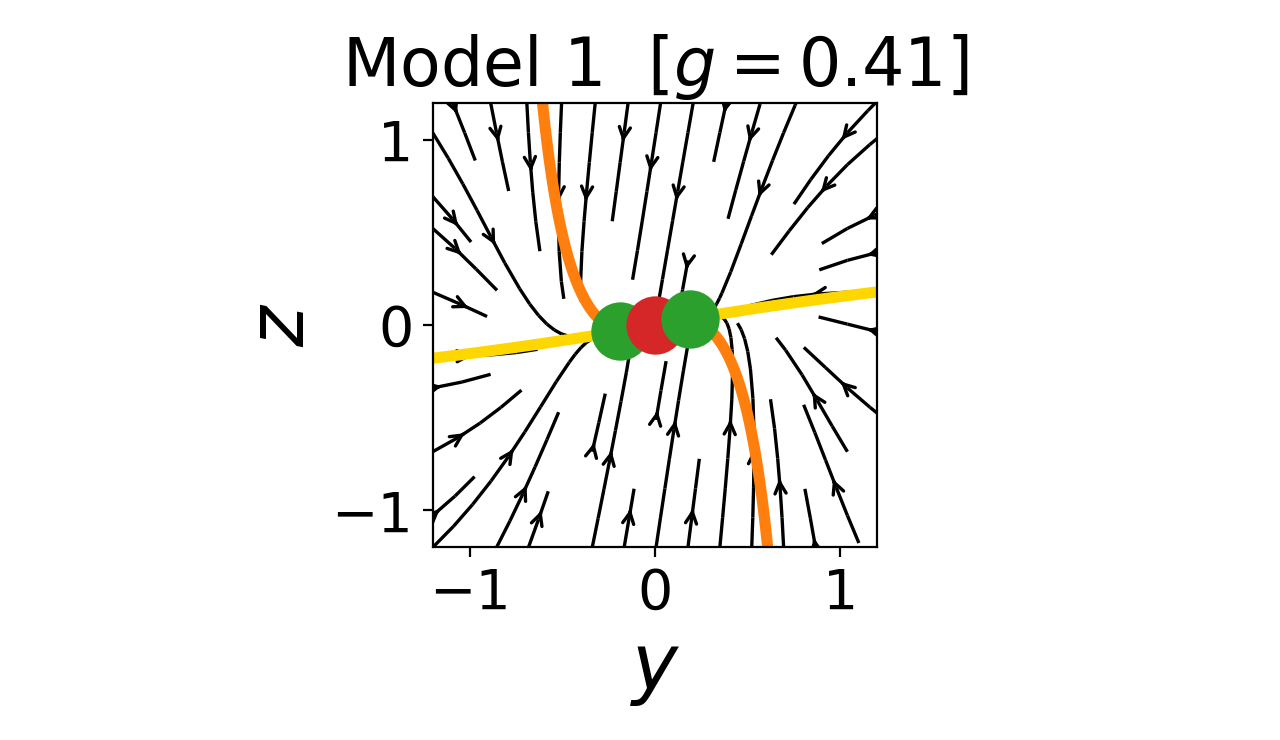

<IPython.core.display.Javascript object>


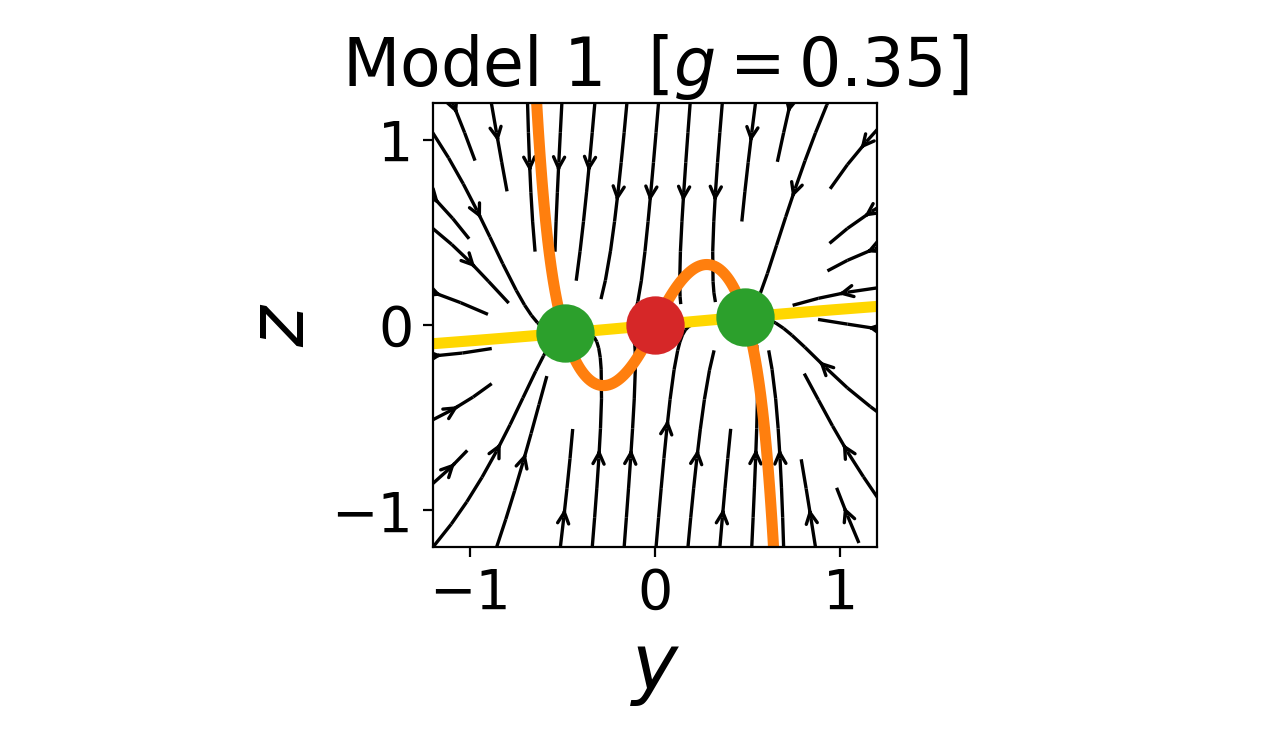

<IPython.core.display.Javascript object>


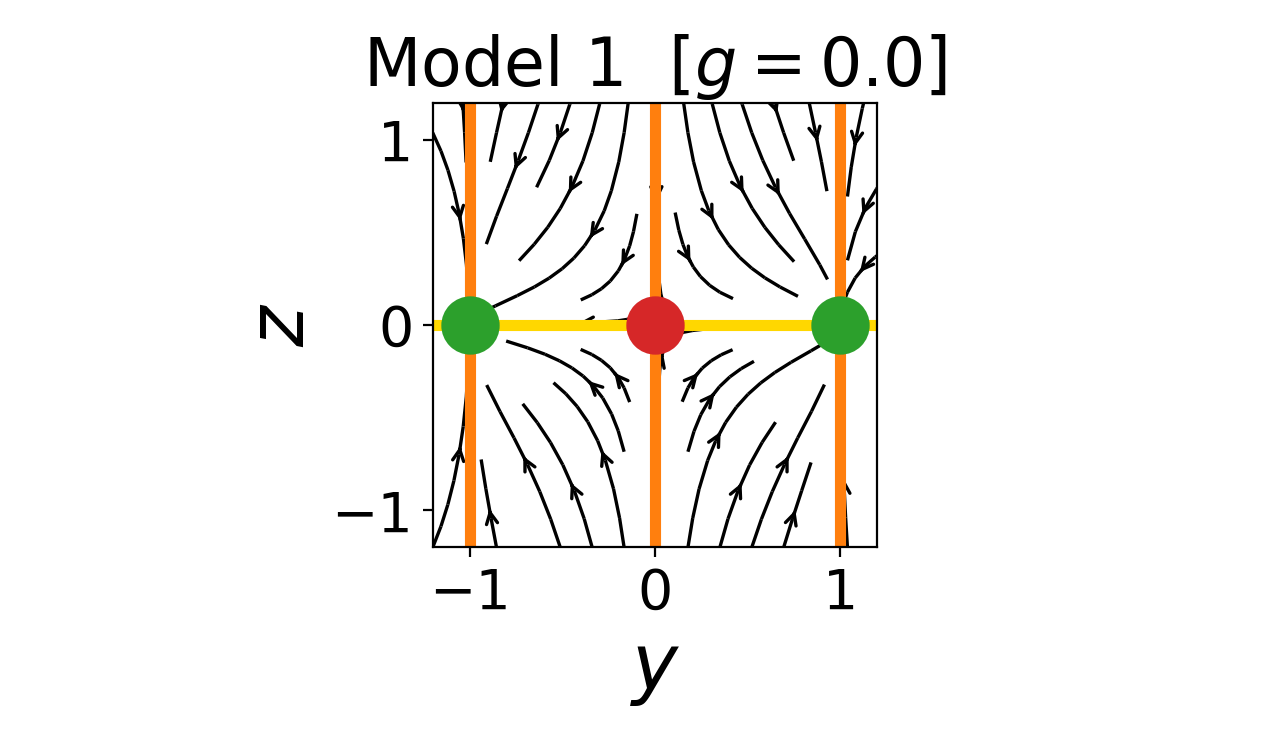

In [22]:
param["ng"] = 3
param["if_interm"] = 1.


# Dynamic module (g=1)
plot_flow(1000, fixed_pts_Hopf, fixed_pts_Hopf_color, cycle_Hopf, 30, 21, param)

# g=0.75
plot_flow(750, fixed_pts_Hopf, fixed_pts_Hopf_color, cycle_Hopf, 62, 24, param)

# Right before the Hopf bifurcation (g=0.64)
plot_flow(640, fixed_pts_Hopf, fixed_pts_Hopf_color, cycle_Hopf, 400, 6, param)

# Right after the Hopf bifurcation (g=0.61)
plot_flow(610, fixed_pts_Hopf, fixed_pts_Hopf_color, cycle_Hopf, 0, 0, param)

# Right before the pitchfork bifurcation (g=0.44)
plot_flow(440, fixed_pts_Hopf, fixed_pts_Hopf_color, cycle_Hopf, 0, 0, param)

# Right after the pitchfork bifurcations (g=0.41)
plot_flow(410, fixed_pts_Hopf, fixed_pts_Hopf_color, cycle_Hopf, 0, 0, param)

# g=0.35
plot_flow(350, fixed_pts_Hopf, fixed_pts_Hopf_color, cycle_Hopf, 0, 0, param)

# Static module (g=0)
plot_flow(0, fixed_pts_Hopf, fixed_pts_Hopf_color, cycle_Hopf, 0, 0, param)

We see that the limit cycle remains almost perfectly symmetrical when $g$ decreases, and that the speed along the cycle is constant. After the cycle disappears during the Hopf bifurcation, the flow spirals towards the single remaining fixed point at the origin. Then, this fixed point loses its stability as two stable fixed points form besides it during the pitchfork bifurcation. This bifurcation occurs when the $z$ nullcline becomes almost horizontal and traverses the $y$ nullcline. When the two stable fixed points form, they divide the flow in two distinct basins of attraction. The regions occupied by these two basins of attraction slighlty change as the stable fixed points reach their final positions at [$y$, $z$] = [-1, 0] and [1, 0].

In the following code cell, we confirm these observations by generating a movie showing the dynamics of the flow as parameter $g$ goes from 1 to 0. Note that creating the movie can take quite some time.

In [ ]:
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()


def animate_flow(frame):
    
    g_index = -frame-1
    ax.clear()
    
    fig.subplots_adjust(bottom = 0.2)
    
    # Flow
    ax.streamplot(Y_grid, Z_grid, dy(Y_grid, Z_grid, g_array[g_index], param), dz(Y_grid, Z_grid, g_array[g_index], param), color='k', density=0.5, linewidth=1.2, arrowstyle='->', zorder=0)
    
    # Nullclines
    ax.contour(Y_grid, Z_grid, dy(Y_grid, Z_grid, g_array[g_index], param), levels=[0], colors='tab:orange', linewidths=4)
    ax.contour(Y_grid, Z_grid, dz(Y_grid, Z_grid, g_array[g_index], param), levels=[0], colors='gold', linewidths=4)
    
    # Limit cycles
    if (g_array[g_index] > 0.617):
        ax.scatter(cycle_Hopf[g_index][0], cycle_Hopf[g_index][1], c='gainsboro', lw=4, zorder=9)
    
    # Fixed points
    for j in range(len(fixed_pts_Hopf[g_index])):
        ax.scatter(fixed_pts_Hopf[g_index][j][0], fixed_pts_Hopf[g_index][j][1], color=fixed_pts_Hopf_color[g_index][j], s=400, zorder=8)

    # Plot options
    ax.set_title('Model 1  $[g=%1.3f]$' %g_array[g_index], fontsize=20)
    ax.set_xlabel('$y$', fontsize=20)
    ax.set_ylabel('$z$', fontsize=20)
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_aspect('equal')
    ax.tick_params(labelsize=20)
    
    

animation = FuncAnimation(fig, animate_flow, len(g_array), interval=20)

writer = writers['ffmpeg'](fps=50)
animation.save('Gene-free_Hopf_flow_movie.mp4', writer=writer, dpi=300)

fig.show()

####   

**3.6 The flow of the gene-free model with a SNIC bifurcation**

We first visualise how the limit cycle deforms from its initial shape, before plotting the flow right before and after the SNIC bifurcation. Then, we visualise how the stable fixed points defining the regions of the pattern move to their final positions.

<IPython.core.display.Javascript object>


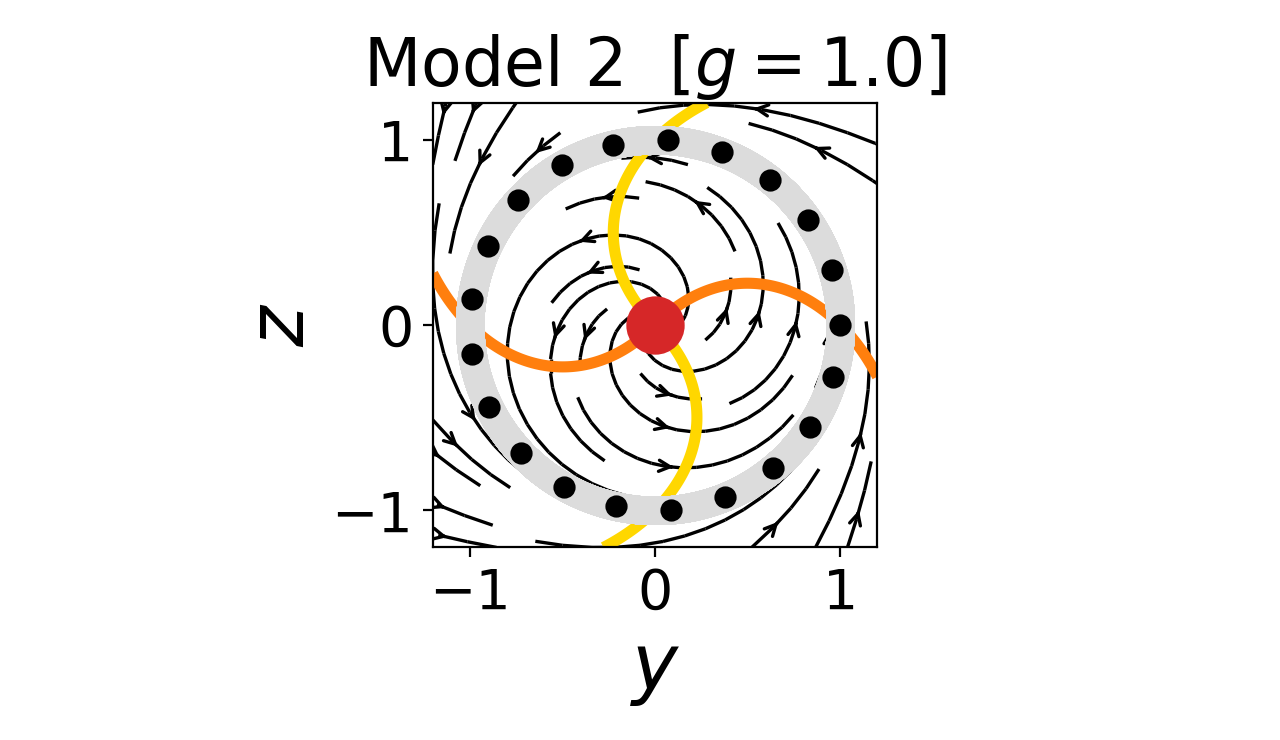

<IPython.core.display.Javascript object>


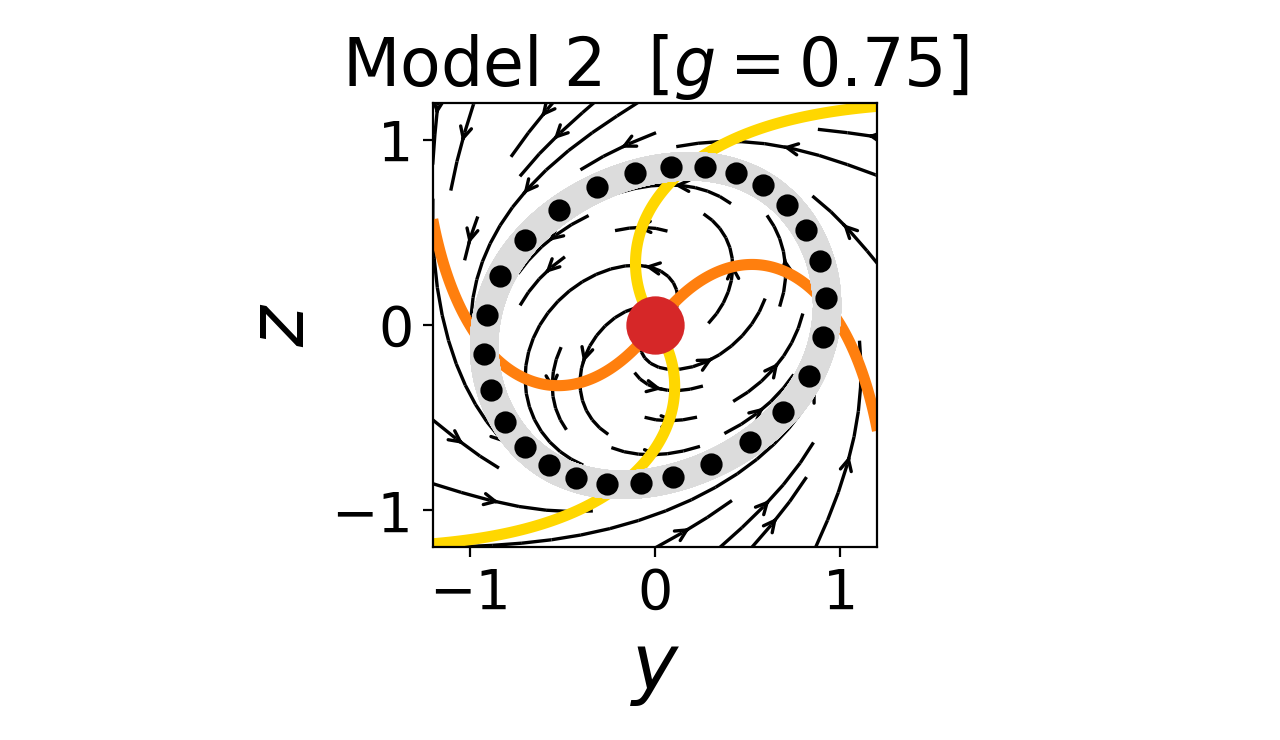

<IPython.core.display.Javascript object>


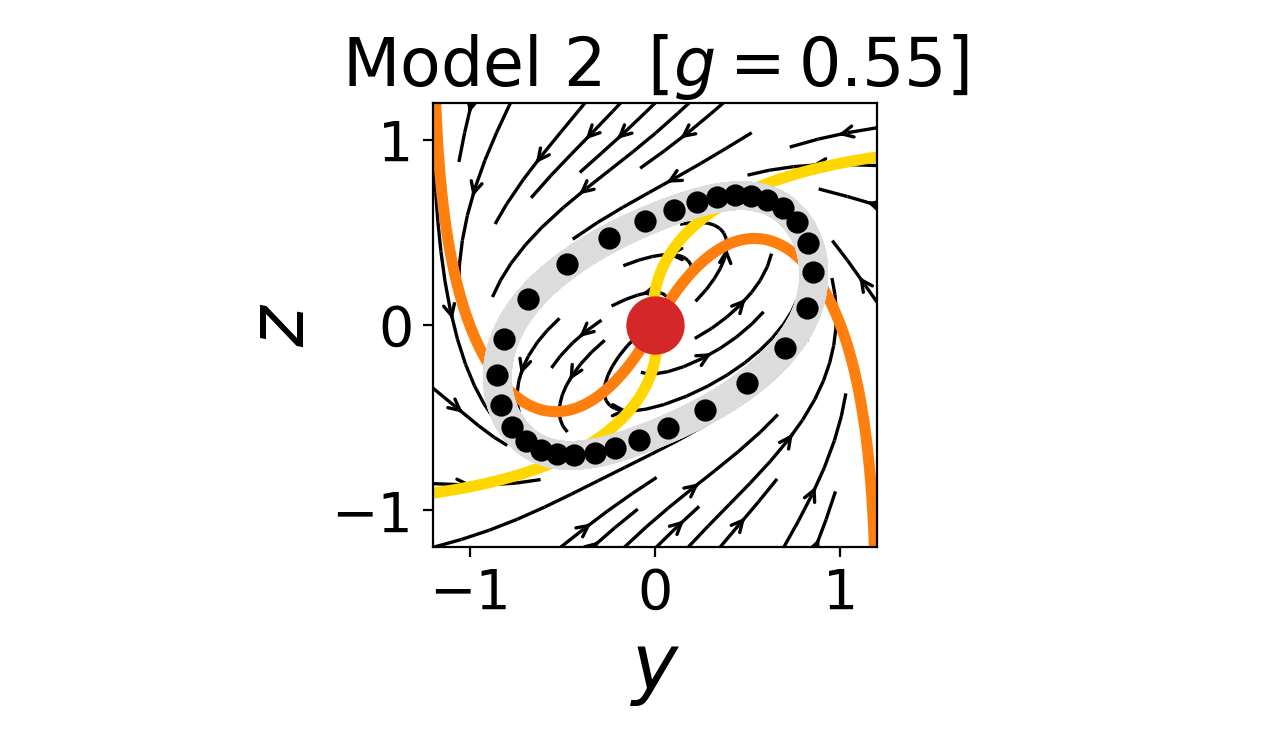

<IPython.core.display.Javascript object>


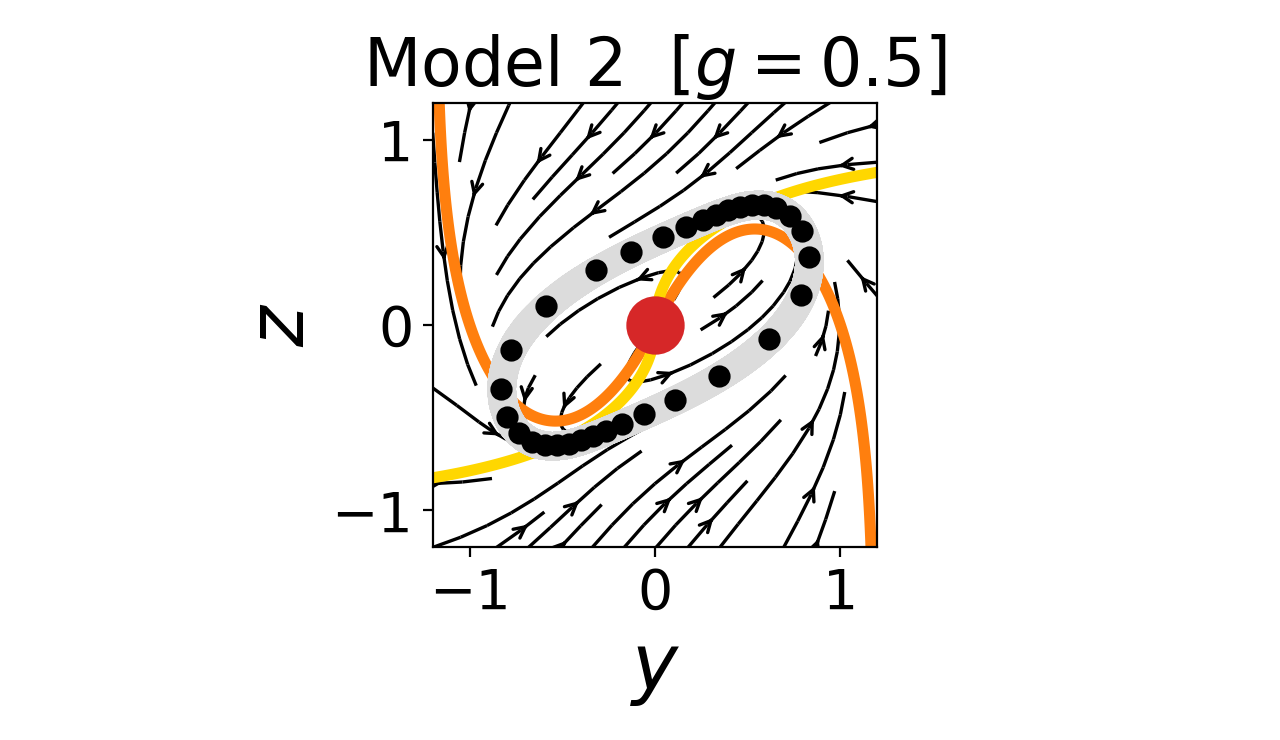

<IPython.core.display.Javascript object>


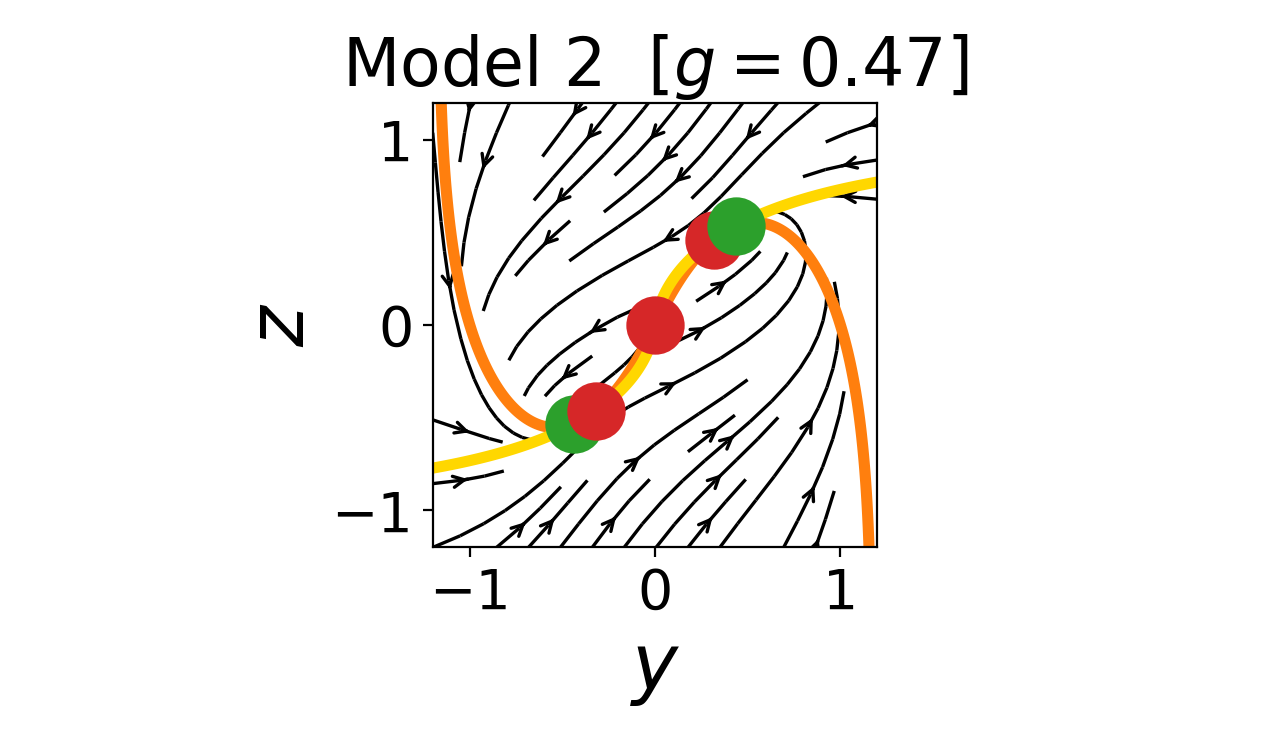

<IPython.core.display.Javascript object>


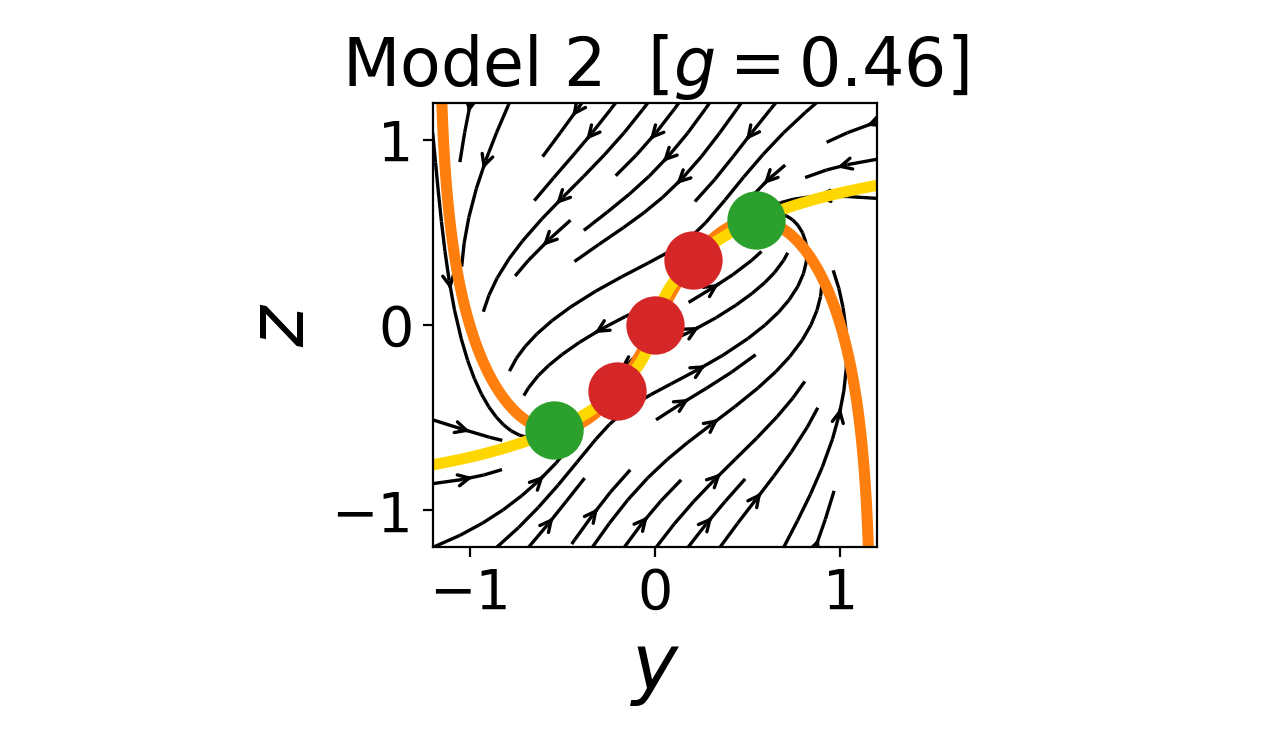

<IPython.core.display.Javascript object>


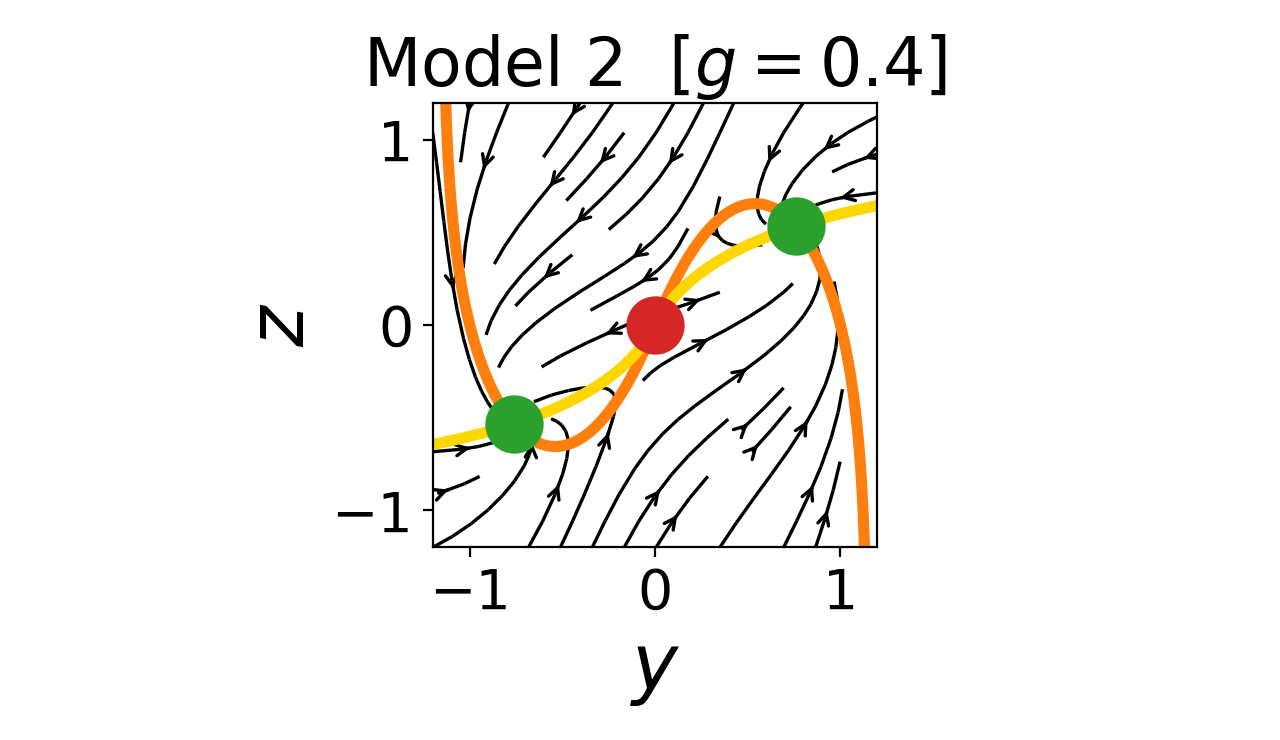

<IPython.core.display.Javascript object>


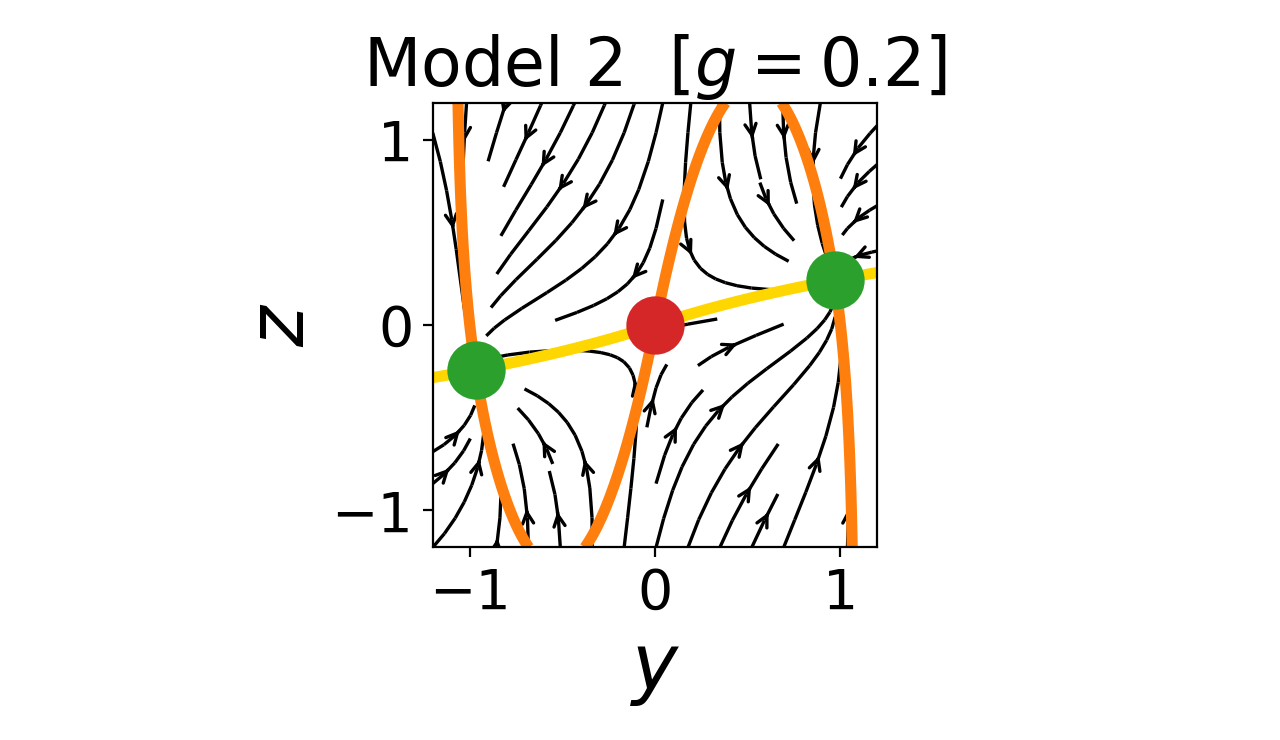

<IPython.core.display.Javascript object>


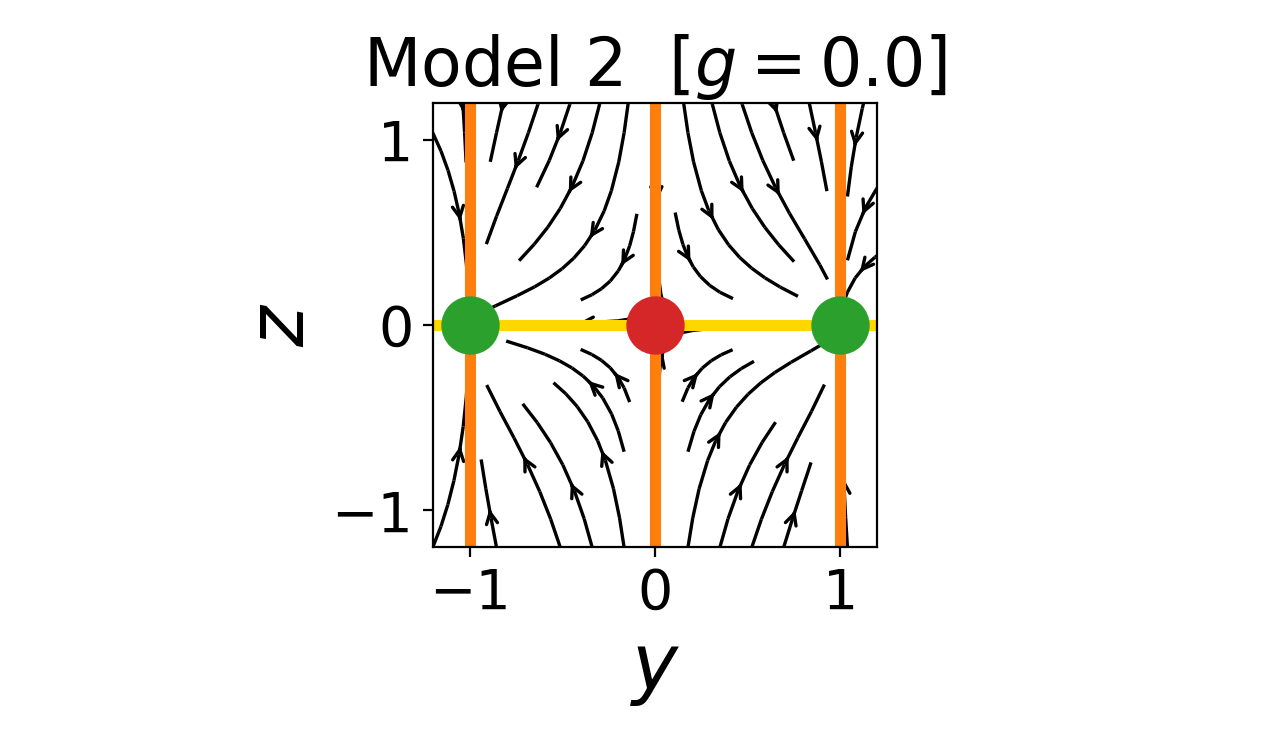

In [23]:
param["ng"] = 1
param["if_interm"] = 0.


# Dynamic module (g=1)
plot_flow(1000, fixed_pts_SNIC, fixed_pts_SNIC_color, cycle_SNIC, 30, 21, param)

# g=0.7
plot_flow(750, fixed_pts_SNIC, fixed_pts_SNIC_color, cycle_SNIC, 31, 28, param)

# g=0.55
plot_flow(550, fixed_pts_SNIC, fixed_pts_SNIC_color, cycle_SNIC, 50, 30, param)

# Right before the SNIC bifurcation (g=0.5)
plot_flow(500, fixed_pts_SNIC, fixed_pts_SNIC_color, cycle_SNIC, 70, 32, param)

# Right after the SNIC bifurcation (g=0.47)
plot_flow(470, fixed_pts_SNIC, fixed_pts_SNIC_color, cycle_SNIC, 0, 0, param)

# g=0.46
plot_flow(460, fixed_pts_SNIC, fixed_pts_SNIC_color, cycle_SNIC, 0, 0, param)

# g=0.4
plot_flow(400, fixed_pts_SNIC, fixed_pts_SNIC_color, cycle_SNIC, 0, 0, param)

# g=0.2
plot_flow(200, fixed_pts_SNIC, fixed_pts_SNIC_color, cycle_SNIC, 0, 0, param)

# Static module (g=0)
plot_flow(0, fixed_pts_SNIC, fixed_pts_SNIC_color, cycle_SNIC, 0, 0, param)

At first, as $g$ decreases, the limit cycle remains almost perfectly symmetric, and the speed stays somewhat constant along the cycle. However, as $g$ decreases further, the limit cycle quickly deforms into an asymmetrical shape and the oscillations become relaxation-like. Right before the SNIC bifurcation, the speed varies greatly along the cycle: the cells move quickly towards the part of the cycle that is near the position where one of the stable fixed points will form, then slow down greatly and stay for a long time in this region of phase space, before accelerating again towards the position where the other stable fixed points will form and staying there for a long time. This behavior is very different from the one observed in Model 1.

When the $y$ and $z$ nullclines collide, pairs of stable and unstable fixed points form via saddle-node bifurcations. Since these pairs of saddles and nodes form directly on the limit cycle, they break it by the same token (this is why it's called a Saddle-Node on Invariant Cycle (SNIC) bifurcation). After the SNIC bifurcation, the flow is divided in two basins of attractions. When the $z$ nullcline traverses completely the $y$ nullcline, the two unstable fixed points created during the SNIC bifurcation merge with the unstable fixed point at the origin. Lastly, the two basins of attraction deform until the stable fixed points reach their final positions at [$y$, $z$] = [-1, 0] and [1, 0].


In the following code cell, we confirm these observations by generating a movie showing the dynamics of the flow as parameter $g$ goes from 1 to 0. Note that creating the movie can take quite some time.

In [ ]:
plt.rcParams["figure.figsize"] = 6.4, 3.7
fig, ax = plt.subplots()


def animate_flow(frame):
    
    g_index = -frame-1
    ax.clear()
    
    fig.subplots_adjust(bottom = 0.2)
    
    # Flow
    ax.streamplot(Y_grid, Z_grid, dy(Y_grid, Z_grid, g_array[g_index], param), dz(Y_grid, Z_grid, g_array[g_index], param), color='k', density=0.5, linewidth=1.2, arrowstyle='->', zorder=0)
    
    # Nullclines
    ax.contour(Y_grid, Z_grid, dy(Y_grid, Z_grid, g_array[g_index], param), levels=[0], colors='tab:orange', linewidths=4)
    ax.contour(Y_grid, Z_grid, dz(Y_grid, Z_grid, g_array[g_index], param), levels=[0], colors='gold', linewidths=4)
    
    # Limit cycles
    if (g_array[g_index] > 0.4715):
        ax.scatter(cycle_SNIC[g_index][0], cycle_SNIC[g_index][1], c='gainsboro', lw=4, zorder=9)
    
    # Fixed points
    for j in range(len(fixed_pts_SNIC[g_index])):
        ax.scatter(fixed_pts_SNIC[g_index][j][0], fixed_pts_SNIC[g_index][j][1], color=fixed_pts_SNIC_color[g_index][j], s=400, zorder=8)

    # Plot options
    ax.set_title('Model 2  $[g=%1.3f]$' %g_array[g_index], fontsize=20)
    ax.set_xlabel('$y$', fontsize=20)
    ax.set_ylabel('$z$', fontsize=20)
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_aspect('equal')
    ax.tick_params(labelsize=20)
    
    

animation = FuncAnimation(fig, animate_flow, len(g_array), interval=20)

writer = writers['ffmpeg'](fps=50)
animation.save('Gene-free_SNIC_flow_movie.mp4', writer=writer, dpi=300)

fig.show()